# Out-of-sample forecasting experiments

I conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Investment, and Consumption) more.

In this notebook, I evaluate the performance of dynamic factor models (DFM) using hard data, survey information, and 10 topics most highly correlated with Consumption growth (out of 200 topics estimated on articles published before 2008 using all sources). I forecast Consumption growth and integrate text data into economic forecasting.

## Experiment Details

- **Data Sources:** Hard data, surveys, 10 topics (<=2007, 200 topics, all sources).
- **Forecast Target:** Consumption growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Global Factors:** 1 to 3
  - **Factor Order:** 1 to 3 (for each number of factors)

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function

# Define inputs common to all models
q_var = 'Consumption'              # quarterly variable being forecasted
additional_factors = None          # or "all" or e.g. ['Labor market']
start = '1991-04'
text_type = "topics"
estimation_period = "2007"
num_topics = "200"
source = "all"
with_text = True

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
    
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)
os.makedirs(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual.csv"
actual_growth = pd.read_csv(actual_growth_file)

# Record overall start time
overall_start = time.time()

# Loop over the number of factors and factor order values from 1 to 3
for num_factors in range(1, 4):  # Varying number of Global factors: 1, 2, 3
    for order in range(1, 4):    # Varying factor order: 1, 2, 3
        
        # Define model-specific parameters
        factor_multiplicities = {'Global': num_factors}
        factor_orders = {'Global': order}

        # Prepare lists to store each quarter's forecasts and row labels
        forecasts_all_quarters = []
        row_labels = []
        
        # Start timing for this model
        start_time = time.time()

        # Loop over each forecast month, get the forecasts, and store the results
        for fm in forecast_months:
            # Use the forecast_month string as the row label
            row_labels.append(fm)

            # Run the forecast function for this quarter
            forecasts_dict = DFM_function.get_forecasts(
                forecast_month = fm,
                q_var = q_var,
                additional_factors = additional_factors,
                factor_multiplicities = factor_multiplicities,
                factor_orders = factor_orders,
                start = start,
                text_type = text_type,
                estimation_period = estimation_period,
                num_topics = num_topics,
                source = source,
                with_text = with_text
            )

            # Obtain the correct ordering of vintages
            vintages_order = DFM_function.vintage_dates(fm)
            # Extract the forecast value for each vintage in that order
            quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
            forecasts_all_quarters.append(quarter_forecasts)

        # Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
        results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)
        
        # Stop timing for this model and print elapsed time
        elapsed = time.time() - start_time
        elapsed_time = datetime.timedelta(seconds=elapsed)
        print(f"Model with Global factors = {num_factors} and order = {order} estimated in {elapsed_time}.")

        # Construct the output file name
        factors_str = "_".join([
            f"{factor.replace(' ', '_')}_{factor_multiplicities[factor]}_{factor_orders[factor]}"
            for factor in factor_multiplicities])
        file_name = f"forecasts_{q_var}_{factors_str}.csv"

        # Save the CSV file in a subfolder 
        output_path = os.path.join(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", file_name)
        results.to_csv(output_path, index=True)
        
        # ----- MSE Calculation -----
        # Load forecasts
        forecasts = pd.read_csv(output_path, index_col=0)
        # Make sure the index is a column named "date"
        forecasts.index.name = "date"
        forecasts.reset_index(inplace=True)

        # Merge dfs by date 
        merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

        # Calculate the Mean Squared Error (MSE) for each vintage column
        mse_dict = {}
        for col in vintage_col_names:
            mse = ((merged[col] - merged["growth"]) ** 2).mean()
            mse_dict[col] = mse

        # Create a df with one row (the MSE values for each forecasting horizon)
        mse_df = pd.DataFrame(mse_dict, index=[0])

        # Save MSE results to CSV
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_output_path = os.path.join(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", mse_file_name)
        mse_df.to_csv(mse_output_path, index=False)
        
# Stop overall timing and print overall elapsed time
overall_elapsed = time.time() - overall_start
overall_elapsed_time = datetime.timedelta(seconds=overall_elapsed)
print(f"Overall time taken for running all models: {overall_elapsed_time}.")

EM start iterations, llf=-11761
EM iteration 50, llf=-11537, convergence criterion=1.353e-06
EM converged at iteration 58, llf=-11537, convergence criterion=9.9294e-07 < tolerance=1e-06
EM start iterations, llf=-11774
EM iteration 50, llf=-11549, convergence criterion=1.3516e-06
EM converged at iteration 58, llf=-11549, convergence criterion=9.919e-07 < tolerance=1e-06
EM start iterations, llf=-11824
EM iteration 50, llf=-11597, convergence criterion=1.3467e-06
EM converged at iteration 58, llf=-11597, convergence criterion=9.8835e-07 < tolerance=1e-06
EM start iterations, llf=-11831
EM iteration 50, llf=-11604, convergence criterion=1.3464e-06
EM converged at iteration 58, llf=-11604, convergence criterion=9.8813e-07 < tolerance=1e-06
EM start iterations, llf=-11894
EM iteration 50, llf=-11663, convergence criterion=1.3705e-06
EM converged at iteration 59, llf=-11663, convergence criterion=9.7219e-07 < tolerance=1e-06
EM start iterations, llf=-11903
EM iteration 50, llf=-11670, conver

EM start iterations, llf=-12868
EM iteration 50, llf=-12681, convergence criterion=1.0488e-06
EM converged at iteration 52, llf=-12681, convergence criterion=9.6757e-07 < tolerance=1e-06
EM start iterations, llf=-12876
EM iteration 50, llf=-12689, convergence criterion=1.048e-06
EM converged at iteration 52, llf=-12689, convergence criterion=9.6689e-07 < tolerance=1e-06
EM start iterations, llf=-12919
EM converged at iteration 49, llf=-12727, convergence criterion=9.6821e-07 < tolerance=1e-06
EM start iterations, llf=-12930
EM converged at iteration 49, llf=-12738, convergence criterion=9.6727e-07 < tolerance=1e-06
EM start iterations, llf=-12988
EM converged at iteration 48, llf=-12801, convergence criterion=9.8167e-07 < tolerance=1e-06
EM start iterations, llf=-12988
EM converged at iteration 48, llf=-12801, convergence criterion=9.8167e-07 < tolerance=1e-06
EM start iterations, llf=-12998
EM converged at iteration 48, llf=-12814, convergence criterion=9.7444e-07 < tolerance=1e-06
EM

EM start iterations, llf=-14612
EM converged at iteration 47, llf=-14435, convergence criterion=9.8852e-07 < tolerance=1e-06
EM start iterations, llf=-14620
EM converged at iteration 47, llf=-14440, convergence criterion=9.9174e-07 < tolerance=1e-06
EM start iterations, llf=-14672
EM converged at iteration 47, llf=-14495, convergence criterion=9.8936e-07 < tolerance=1e-06
EM start iterations, llf=-14672
EM converged at iteration 47, llf=-14495, convergence criterion=9.8936e-07 < tolerance=1e-06
EM start iterations, llf=-14681
EM converged at iteration 47, llf=-14502, convergence criterion=9.8768e-07 < tolerance=1e-06
EM start iterations, llf=-14736
EM converged at iteration 47, llf=-14556, convergence criterion=9.8477e-07 < tolerance=1e-06
EM start iterations, llf=-14744
EM converged at iteration 47, llf=-14563, convergence criterion=9.7917e-07 < tolerance=1e-06
EM start iterations, llf=-14792
EM converged at iteration 46, llf=-14612, convergence criterion=9.7869e-07 < tolerance=1e-06


EM converged at iteration 47, llf=-16115, convergence criterion=9.6472e-07 < tolerance=1e-06
EM start iterations, llf=-16311
EM converged at iteration 47, llf=-16115, convergence criterion=9.6472e-07 < tolerance=1e-06
EM start iterations, llf=-16320
EM converged at iteration 47, llf=-16123, convergence criterion=9.6639e-07 < tolerance=1e-06
EM start iterations, llf=-16373
EM converged at iteration 47, llf=-16175, convergence criterion=9.6261e-07 < tolerance=1e-06
EM start iterations, llf=-16382
EM converged at iteration 47, llf=-16185, convergence criterion=9.6103e-07 < tolerance=1e-06
EM start iterations, llf=-16432
EM converged at iteration 46, llf=-16235, convergence criterion=9.9983e-07 < tolerance=1e-06
EM start iterations, llf=-16440
EM converged at iteration 46, llf=-16242, convergence criterion=9.9979e-07 < tolerance=1e-06
EM start iterations, llf=-16492
EM converged at iteration 46, llf=-16293, convergence criterion=9.9729e-07 < tolerance=1e-06
EM start iterations, llf=-16492


EM converged at iteration 57, llf=-17329, convergence criterion=9.8053e-07 < tolerance=1e-06
EM start iterations, llf=-17585
EM iteration 50, llf=-17377, convergence criterion=1.2532e-06
EM converged at iteration 57, llf=-17377, convergence criterion=9.7786e-07 < tolerance=1e-06
EM start iterations, llf=-17585
EM iteration 50, llf=-17377, convergence criterion=1.2532e-06
EM converged at iteration 57, llf=-17377, convergence criterion=9.7786e-07 < tolerance=1e-06
EM start iterations, llf=-17604
EM iteration 50, llf=-17396, convergence criterion=1.2525e-06
EM converged at iteration 57, llf=-17396, convergence criterion=9.7719e-07 < tolerance=1e-06
EM start iterations, llf=-17656
EM iteration 50, llf=-17447, convergence criterion=1.245e-06
EM converged at iteration 57, llf=-17447, convergence criterion=9.7178e-07 < tolerance=1e-06
EM start iterations, llf=-17663
EM iteration 50, llf=-17454, convergence criterion=1.2446e-06
EM converged at iteration 57, llf=-17454, convergence criterion=9.

EM converged at iteration 57, llf=-18273, convergence criterion=9.8989e-07 < tolerance=1e-06
EM start iterations, llf=-18501
EM iteration 50, llf=-18279, convergence criterion=1.2686e-06
EM converged at iteration 57, llf=-18279, convergence criterion=9.8974e-07 < tolerance=1e-06
EM start iterations, llf=-18555
EM iteration 50, llf=-18332, convergence criterion=1.2655e-06
EM converged at iteration 57, llf=-18332, convergence criterion=9.8731e-07 < tolerance=1e-06
EM start iterations, llf=-18561
EM iteration 50, llf=-18339, convergence criterion=1.2647e-06
EM converged at iteration 57, llf=-18339, convergence criterion=9.8668e-07 < tolerance=1e-06
EM start iterations, llf=-18620
EM iteration 50, llf=-18396, convergence criterion=1.2702e-06
EM converged at iteration 57, llf=-18396, convergence criterion=9.9112e-07 < tolerance=1e-06
EM start iterations, llf=-18627
EM iteration 50, llf=-18403, convergence criterion=1.27e-06
EM converged at iteration 57, llf=-18403, convergence criterion=9.9

EM start iterations, llf=-11824
EM iteration 50, llf=-11594, convergence criterion=1.6635e-06
EM converged at iteration 64, llf=-11594, convergence criterion=9.7923e-07 < tolerance=1e-06
EM start iterations, llf=-11831
EM iteration 50, llf=-11601, convergence criterion=1.6643e-06
EM converged at iteration 64, llf=-11600, convergence criterion=9.7962e-07 < tolerance=1e-06
EM start iterations, llf=-11894
EM iteration 50, llf=-11659, convergence criterion=1.6786e-06
EM converged at iteration 64, llf=-11659, convergence criterion=9.911e-07 < tolerance=1e-06
EM start iterations, llf=-11903
EM iteration 50, llf=-11666, convergence criterion=1.6702e-06
EM converged at iteration 64, llf=-11666, convergence criterion=9.867e-07 < tolerance=1e-06
EM start iterations, llf=-11957
EM iteration 50, llf=-11723, convergence criterion=1.6714e-06
EM converged at iteration 64, llf=-11722, convergence criterion=9.8536e-07 < tolerance=1e-06
EM start iterations, llf=-11957
EM iteration 50, llf=-11723, conver

EM start iterations, llf=-12919
EM iteration 50, llf=-12723, convergence criterion=1.1546e-06
EM converged at iteration 54, llf=-12723, convergence criterion=9.7738e-07 < tolerance=1e-06
EM start iterations, llf=-12930
EM iteration 50, llf=-12734, convergence criterion=1.1498e-06
EM converged at iteration 54, llf=-12734, convergence criterion=9.732e-07 < tolerance=1e-06
EM start iterations, llf=-12988
EM iteration 50, llf=-12797, convergence criterion=1.1527e-06
EM converged at iteration 54, llf=-12797, convergence criterion=9.7825e-07 < tolerance=1e-06
EM start iterations, llf=-12988
EM iteration 50, llf=-12797, convergence criterion=1.1527e-06
EM converged at iteration 54, llf=-12797, convergence criterion=9.7825e-07 < tolerance=1e-06
EM start iterations, llf=-12998
EM iteration 50, llf=-12811, convergence criterion=1.157e-06
EM converged at iteration 54, llf=-12811, convergence criterion=9.8281e-07 < tolerance=1e-06
EM start iterations, llf=-13048
EM iteration 50, llf=-12858, conver

EM start iterations, llf=-14112
EM iteration 50, llf=-13938, convergence criterion=1.29e-06
EM converged at iteration 57, llf=-13938, convergence criterion=9.859e-07 < tolerance=1e-06
EM start iterations, llf=-14112
EM iteration 50, llf=-13938, convergence criterion=1.29e-06
EM converged at iteration 57, llf=-13938, convergence criterion=9.859e-07 < tolerance=1e-06
EM start iterations, llf=-14123
EM iteration 50, llf=-13949, convergence criterion=1.2947e-06
EM converged at iteration 57, llf=-13949, convergence criterion=9.9032e-07 < tolerance=1e-06
EM start iterations, llf=-14175
EM iteration 50, llf=-14001, convergence criterion=1.2855e-06
EM converged at iteration 57, llf=-14001, convergence criterion=9.823e-07 < tolerance=1e-06
EM start iterations, llf=-14183
EM iteration 50, llf=-14008, convergence criterion=1.2652e-06
EM converged at iteration 57, llf=-14008, convergence criterion=9.657e-07 < tolerance=1e-06
EM start iterations, llf=-14242
EM iteration 50, llf=-14067, convergence 

EM start iterations, llf=-15216
EM iteration 50, llf=-15034, convergence criterion=1.2696e-06
EM converged at iteration 57, llf=-15034, convergence criterion=9.8049e-07 < tolerance=1e-06
EM start iterations, llf=-15269
EM iteration 50, llf=-15087, convergence criterion=1.2683e-06
EM converged at iteration 57, llf=-15087, convergence criterion=9.8064e-07 < tolerance=1e-06
EM start iterations, llf=-15280
EM iteration 50, llf=-15098, convergence criterion=1.2745e-06
EM converged at iteration 57, llf=-15098, convergence criterion=9.8587e-07 < tolerance=1e-06
EM start iterations, llf=-15329
EM iteration 50, llf=-15146, convergence criterion=1.2841e-06
EM converged at iteration 57, llf=-15146, convergence criterion=9.9359e-07 < tolerance=1e-06
EM start iterations, llf=-15337
EM iteration 50, llf=-15154, convergence criterion=1.2764e-06
EM converged at iteration 57, llf=-15153, convergence criterion=9.8715e-07 < tolerance=1e-06
EM start iterations, llf=-15383
EM iteration 50, llf=-15199, conv

EM start iterations, llf=-16382
EM iteration 50, llf=-16182, convergence criterion=1.1132e-06
EM converged at iteration 53, llf=-16182, convergence criterion=9.8899e-07 < tolerance=1e-06
EM start iterations, llf=-16432
EM iteration 50, llf=-16232, convergence criterion=1.1135e-06
EM converged at iteration 53, llf=-16232, convergence criterion=9.8942e-07 < tolerance=1e-06
EM start iterations, llf=-16440
EM iteration 50, llf=-16239, convergence criterion=1.11e-06
EM converged at iteration 53, llf=-16239, convergence criterion=9.8616e-07 < tolerance=1e-06
EM start iterations, llf=-16492
EM iteration 50, llf=-16290, convergence criterion=1.1061e-06
EM converged at iteration 53, llf=-16290, convergence criterion=9.8251e-07 < tolerance=1e-06
EM start iterations, llf=-16492
EM iteration 50, llf=-16290, convergence criterion=1.1061e-06
EM converged at iteration 53, llf=-16290, convergence criterion=9.8251e-07 < tolerance=1e-06
EM start iterations, llf=-16502
EM iteration 50, llf=-16302, conver

EM start iterations, llf=-17537
EM iteration 50, llf=-17327, convergence criterion=1.453e-06
EM converged at iteration 61, llf=-17327, convergence criterion=9.9138e-07 < tolerance=1e-06
EM start iterations, llf=-17585
EM iteration 50, llf=-17375, convergence criterion=1.4478e-06
EM converged at iteration 61, llf=-17374, convergence criterion=9.879e-07 < tolerance=1e-06
EM start iterations, llf=-17585
EM iteration 50, llf=-17375, convergence criterion=1.4478e-06
EM converged at iteration 61, llf=-17374, convergence criterion=9.879e-07 < tolerance=1e-06
EM start iterations, llf=-17604
EM iteration 50, llf=-17394, convergence criterion=1.4486e-06
EM converged at iteration 61, llf=-17394, convergence criterion=9.8819e-07 < tolerance=1e-06
EM start iterations, llf=-17655
EM iteration 50, llf=-17445, convergence criterion=1.4324e-06
EM converged at iteration 61, llf=-17445, convergence criterion=9.7851e-07 < tolerance=1e-06
EM start iterations, llf=-17662
EM iteration 50, llf=-17452, converg

EM start iterations, llf=-18495
EM iteration 50, llf=-18270, convergence criterion=1.4193e-06
EM converged at iteration 60, llf=-18270, convergence criterion=9.9593e-07 < tolerance=1e-06
EM start iterations, llf=-18501
EM iteration 50, llf=-18276, convergence criterion=1.4192e-06
EM converged at iteration 60, llf=-18276, convergence criterion=9.9589e-07 < tolerance=1e-06
EM start iterations, llf=-18554
EM iteration 50, llf=-18329, convergence criterion=1.4157e-06
EM converged at iteration 60, llf=-18329, convergence criterion=9.9321e-07 < tolerance=1e-06
EM start iterations, llf=-18561
EM iteration 50, llf=-18336, convergence criterion=1.414e-06
EM converged at iteration 60, llf=-18336, convergence criterion=9.9202e-07 < tolerance=1e-06
EM start iterations, llf=-18619
EM iteration 50, llf=-18393, convergence criterion=1.4249e-06
EM converged at iteration 61, llf=-18392, convergence criterion=9.6847e-07 < tolerance=1e-06
EM start iterations, llf=-18627
EM iteration 50, llf=-18400, conve

EM converged at iteration 62, llf=-11536, convergence criterion=9.7893e-07 < tolerance=1e-06
EM start iterations, llf=-11816
EM iteration 50, llf=-11586, convergence criterion=1.5707e-06
EM converged at iteration 62, llf=-11585, convergence criterion=9.8451e-07 < tolerance=1e-06
EM start iterations, llf=-11822
EM iteration 50, llf=-11593, convergence criterion=1.5711e-06
EM converged at iteration 62, llf=-11592, convergence criterion=9.8468e-07 < tolerance=1e-06
EM start iterations, llf=-11886
EM iteration 50, llf=-11651, convergence criterion=1.5885e-06
EM converged at iteration 62, llf=-11651, convergence criterion=9.9896e-07 < tolerance=1e-06
EM start iterations, llf=-11894
EM iteration 50, llf=-11658, convergence criterion=1.5806e-06
EM converged at iteration 62, llf=-11657, convergence criterion=9.9468e-07 < tolerance=1e-06
EM start iterations, llf=-11949
EM iteration 50, llf=-11714, convergence criterion=1.5777e-06
EM converged at iteration 62, llf=-11714, convergence criterion=9

EM converged at iteration 58, llf=-12677, convergence criterion=9.875e-07 < tolerance=1e-06
EM start iterations, llf=-12913
EM iteration 50, llf=-12716, convergence criterion=1.2174e-06
EM converged at iteration 55, llf=-12716, convergence criterion=9.8298e-07 < tolerance=1e-06
EM start iterations, llf=-12924
EM iteration 50, llf=-12726, convergence criterion=1.2099e-06
EM converged at iteration 55, llf=-12726, convergence criterion=9.7704e-07 < tolerance=1e-06
EM start iterations, llf=-12982
EM iteration 50, llf=-12791, convergence criterion=1.255e-06
EM converged at iteration 56, llf=-12791, convergence criterion=9.7513e-07 < tolerance=1e-06
EM start iterations, llf=-12982
EM iteration 50, llf=-12791, convergence criterion=1.255e-06
EM converged at iteration 56, llf=-12791, convergence criterion=9.7513e-07 < tolerance=1e-06
EM start iterations, llf=-12992
EM iteration 50, llf=-12805, convergence criterion=1.2665e-06
EM converged at iteration 56, llf=-12805, convergence criterion=9.85

EM converged at iteration 56, llf=-13886, convergence criterion=9.8018e-07 < tolerance=1e-06
EM start iterations, llf=-14102
EM iteration 50, llf=-13933, convergence criterion=1.2941e-06
EM converged at iteration 57, llf=-13933, convergence criterion=9.6909e-07 < tolerance=1e-06
EM start iterations, llf=-14102
EM iteration 50, llf=-13933, convergence criterion=1.2941e-06
EM converged at iteration 57, llf=-13933, convergence criterion=9.6909e-07 < tolerance=1e-06
EM start iterations, llf=-14113
EM iteration 50, llf=-13944, convergence criterion=1.2941e-06
EM converged at iteration 57, llf=-13944, convergence criterion=9.6945e-07 < tolerance=1e-06
EM start iterations, llf=-14166
EM iteration 50, llf=-13996, convergence criterion=1.2814e-06
EM converged at iteration 56, llf=-13996, convergence criterion=9.9743e-07 < tolerance=1e-06
EM start iterations, llf=-14174
EM iteration 50, llf=-14003, convergence criterion=1.2677e-06
EM converged at iteration 56, llf=-14003, convergence criterion=9

EM converged at iteration 57, llf=-15020, convergence criterion=9.7958e-07 < tolerance=1e-06
EM start iterations, llf=-15208
EM iteration 50, llf=-15030, convergence criterion=1.2937e-06
EM converged at iteration 57, llf=-15030, convergence criterion=9.7931e-07 < tolerance=1e-06
EM start iterations, llf=-15261
EM iteration 50, llf=-15082, convergence criterion=1.2909e-06
EM converged at iteration 57, llf=-15082, convergence criterion=9.7789e-07 < tolerance=1e-06
EM start iterations, llf=-15271
EM iteration 50, llf=-15093, convergence criterion=1.2884e-06
EM converged at iteration 57, llf=-15093, convergence criterion=9.7618e-07 < tolerance=1e-06
EM start iterations, llf=-15321
EM iteration 50, llf=-15142, convergence criterion=1.297e-06
EM converged at iteration 57, llf=-15142, convergence criterion=9.83e-07 < tolerance=1e-06
EM start iterations, llf=-15328
EM iteration 50, llf=-15149, convergence criterion=1.2907e-06
EM converged at iteration 57, llf=-15149, convergence criterion=9.78

EM converged at iteration 55, llf=-16167, convergence criterion=9.8928e-07 < tolerance=1e-06
EM start iterations, llf=-16373
EM iteration 50, llf=-16177, convergence criterion=1.2135e-06
EM converged at iteration 55, llf=-16176, convergence criterion=9.8801e-07 < tolerance=1e-06
EM start iterations, llf=-16423
EM iteration 50, llf=-16226, convergence criterion=1.2074e-06
EM converged at iteration 55, llf=-16226, convergence criterion=9.8313e-07 < tolerance=1e-06
EM start iterations, llf=-16430
EM iteration 50, llf=-16234, convergence criterion=1.2044e-06
EM converged at iteration 55, llf=-16234, convergence criterion=9.8053e-07 < tolerance=1e-06
EM start iterations, llf=-16482
EM iteration 50, llf=-16285, convergence criterion=1.2012e-06
EM converged at iteration 55, llf=-16284, convergence criterion=9.7776e-07 < tolerance=1e-06
EM start iterations, llf=-16482
EM iteration 50, llf=-16285, convergence criterion=1.2012e-06
EM converged at iteration 55, llf=-16284, convergence criterion=9

EM converged at iteration 63, llf=-17315, convergence criterion=9.6898e-07 < tolerance=1e-06
EM start iterations, llf=-17528
EM iteration 50, llf=-17322, convergence criterion=1.5335e-06
EM converged at iteration 62, llf=-17322, convergence criterion=9.9771e-07 < tolerance=1e-06
EM start iterations, llf=-17576
EM iteration 50, llf=-17369, convergence criterion=1.5283e-06
EM converged at iteration 62, llf=-17369, convergence criterion=9.9456e-07 < tolerance=1e-06
EM start iterations, llf=-17576
EM iteration 50, llf=-17369, convergence criterion=1.5283e-06
EM converged at iteration 62, llf=-17369, convergence criterion=9.9456e-07 < tolerance=1e-06
EM start iterations, llf=-17595
EM iteration 50, llf=-17388, convergence criterion=1.53e-06
EM converged at iteration 62, llf=-17388, convergence criterion=9.9527e-07 < tolerance=1e-06
EM start iterations, llf=-17646
EM iteration 50, llf=-17440, convergence criterion=1.5086e-06
EM converged at iteration 62, llf=-17440, convergence criterion=9.8

EM converged at iteration 62, llf=-18264, convergence criterion=9.7304e-07 < tolerance=1e-06
EM start iterations, llf=-18486
EM iteration 50, llf=-18264, convergence criterion=1.4959e-06
EM converged at iteration 62, llf=-18264, convergence criterion=9.7304e-07 < tolerance=1e-06
EM start iterations, llf=-18491
EM iteration 50, llf=-18269, convergence criterion=1.4961e-06
EM converged at iteration 62, llf=-18269, convergence criterion=9.7317e-07 < tolerance=1e-06
EM start iterations, llf=-18545
EM iteration 50, llf=-18322, convergence criterion=1.4916e-06
EM converged at iteration 62, llf=-18322, convergence criterion=9.7005e-07 < tolerance=1e-06
EM start iterations, llf=-18552
EM iteration 50, llf=-18329, convergence criterion=1.4898e-06
EM converged at iteration 62, llf=-18329, convergence criterion=9.689e-07 < tolerance=1e-06
EM start iterations, llf=-18610
EM iteration 50, llf=-18386, convergence criterion=1.4982e-06
EM converged at iteration 62, llf=-18386, convergence criterion=9.

EM iteration 50, llf=-11163, convergence criterion=1.0059e-06
EM converged at iteration 51, llf=-11163, convergence criterion=9.6701e-07 < tolerance=1e-06
EM start iterations, llf=-11340
EM iteration 50, llf=-11213, convergence criterion=9.9899e-07
EM converged at iteration 50, llf=-11213, convergence criterion=9.9899e-07 < tolerance=1e-06
EM start iterations, llf=-11348
EM iteration 50, llf=-11221, convergence criterion=9.9442e-07
EM converged at iteration 50, llf=-11221, convergence criterion=9.9442e-07 < tolerance=1e-06
EM start iterations, llf=-11404
EM iteration 50, llf=-11277, convergence criterion=9.9884e-07
EM converged at iteration 50, llf=-11277, convergence criterion=9.9884e-07 < tolerance=1e-06
EM start iterations, llf=-11414
EM iteration 50, llf=-11286, convergence criterion=9.8487e-07
EM converged at iteration 50, llf=-11286, convergence criterion=9.8487e-07 < tolerance=1e-06
EM start iterations, llf=-11471
EM iteration 50, llf=-11339, convergence criterion=1.0028e-06
EM 

EM start iterations, llf=-12567
EM converged at iteration 45, llf=-12434, convergence criterion=9.6e-07 < tolerance=1e-06
EM start iterations, llf=-12615
EM converged at iteration 44, llf=-12483, convergence criterion=9.9701e-07 < tolerance=1e-06
EM start iterations, llf=-12626
EM converged at iteration 44, llf=-12495, convergence criterion=9.9681e-07 < tolerance=1e-06
EM start iterations, llf=-12670
EM converged at iteration 47, llf=-12540, convergence criterion=9.6729e-07 < tolerance=1e-06
EM start iterations, llf=-12719
EM converged at iteration 46, llf=-12587, convergence criterion=9.9177e-07 < tolerance=1e-06
EM start iterations, llf=-12756
EM converged at iteration 46, llf=-12626, convergence criterion=9.9907e-07 < tolerance=1e-06
EM start iterations, llf=-12756
EM converged at iteration 46, llf=-12626, convergence criterion=9.9907e-07 < tolerance=1e-06
EM start iterations, llf=-12769
EM converged at iteration 46, llf=-12638, convergence criterion=9.9877e-07 < tolerance=1e-06
EM 

EM start iterations, llf=-14244
EM converged at iteration 44, llf=-14106, convergence criterion=9.716e-07 < tolerance=1e-06
EM start iterations, llf=-14253
EM converged at iteration 44, llf=-14115, convergence criterion=9.7153e-07 < tolerance=1e-06
EM start iterations, llf=-14305
EM converged at iteration 44, llf=-14164, convergence criterion=9.7139e-07 < tolerance=1e-06
EM start iterations, llf=-14305
EM converged at iteration 44, llf=-14164, convergence criterion=9.7139e-07 < tolerance=1e-06
EM start iterations, llf=-14310
EM converged at iteration 44, llf=-14170, convergence criterion=9.7154e-07 < tolerance=1e-06
EM start iterations, llf=-14356
EM converged at iteration 44, llf=-14218, convergence criterion=9.6611e-07 < tolerance=1e-06
EM start iterations, llf=-14368
EM converged at iteration 44, llf=-14227, convergence criterion=9.6297e-07 < tolerance=1e-06
EM start iterations, llf=-14420
EM converged at iteration 45, llf=-14281, convergence criterion=9.8877e-07 < tolerance=1e-06
E

EM iteration 50, llf=-15748, convergence criterion=1.2618e-06
EM converged at iteration 57, llf=-15748, convergence criterion=9.795e-07 < tolerance=1e-06
EM start iterations, llf=-15893
EM iteration 50, llf=-15748, convergence criterion=1.2618e-06
EM converged at iteration 57, llf=-15748, convergence criterion=9.795e-07 < tolerance=1e-06
EM start iterations, llf=-15894
EM iteration 50, llf=-15749, convergence criterion=1.2724e-06
EM converged at iteration 57, llf=-15748, convergence criterion=9.8737e-07 < tolerance=1e-06
EM start iterations, llf=-15941
EM iteration 50, llf=-15796, convergence criterion=1.2733e-06
EM converged at iteration 57, llf=-15796, convergence criterion=9.8796e-07 < tolerance=1e-06
EM start iterations, llf=-15948
EM iteration 50, llf=-15802, convergence criterion=1.2588e-06
EM converged at iteration 57, llf=-15802, convergence criterion=9.7724e-07 < tolerance=1e-06
EM start iterations, llf=-16003
EM iteration 50, llf=-15857, convergence criterion=1.1837e-06
EM co

EM iteration 50, llf=-16810, convergence criterion=1.2167e-06
EM converged at iteration 56, llf=-16810, convergence criterion=9.7969e-07 < tolerance=1e-06
EM start iterations, llf=-17005
EM iteration 50, llf=-16857, convergence criterion=1.2148e-06
EM converged at iteration 56, llf=-16857, convergence criterion=9.781e-07 < tolerance=1e-06
EM start iterations, llf=-17013
EM iteration 50, llf=-16866, convergence criterion=1.2145e-06
EM converged at iteration 56, llf=-16866, convergence criterion=9.7782e-07 < tolerance=1e-06
EM start iterations, llf=-17071
EM iteration 50, llf=-16922, convergence criterion=1.2309e-06
EM converged at iteration 56, llf=-16921, convergence criterion=9.9113e-07 < tolerance=1e-06
EM start iterations, llf=-17076
EM iteration 50, llf=-16928, convergence criterion=1.2308e-06
EM converged at iteration 56, llf=-16928, convergence criterion=9.91e-07 < tolerance=1e-06
EM start iterations, llf=-17127
EM iteration 50, llf=-16978, convergence criterion=1.2244e-06
EM con

EM iteration 50, llf=-17735, convergence criterion=1.2046e-06
EM converged at iteration 56, llf=-17735, convergence criterion=9.6921e-07 < tolerance=1e-06
EM start iterations, llf=-17934
EM iteration 50, llf=-17785, convergence criterion=1.2189e-06
EM converged at iteration 56, llf=-17784, convergence criterion=9.8086e-07 < tolerance=1e-06
EM start iterations, llf=-17948
EM iteration 50, llf=-17798, convergence criterion=1.2184e-06
EM converged at iteration 56, llf=-17798, convergence criterion=9.8046e-07 < tolerance=1e-06
EM start iterations, llf=-17993
EM iteration 50, llf=-17842, convergence criterion=1.2136e-06
EM converged at iteration 56, llf=-17842, convergence criterion=9.7666e-07 < tolerance=1e-06
EM start iterations, llf=-17993
EM iteration 50, llf=-17842, convergence criterion=1.2136e-06
EM converged at iteration 56, llf=-17842, convergence criterion=9.7666e-07 < tolerance=1e-06
EM start iterations, llf=-18002
EM iteration 50, llf=-17851, convergence criterion=1.2147e-06
EM 

EM start iterations, llf=-11582
EM iteration 50, llf=-11447, convergence criterion=2.0012e-06
EM converged at iteration 75, llf=-11446, convergence criterion=9.8968e-07 < tolerance=1e-06
EM start iterations, llf=-11622
EM iteration 50, llf=-11487, convergence criterion=1.8569e-06
EM converged at iteration 70, llf=-11487, convergence criterion=9.9562e-07 < tolerance=1e-06
EM start iterations, llf=-11622
EM iteration 50, llf=-11487, convergence criterion=1.8569e-06
EM converged at iteration 70, llf=-11487, convergence criterion=9.9562e-07 < tolerance=1e-06
EM start iterations, llf=-11631
EM iteration 50, llf=-11497, convergence criterion=1.8289e-06
EM converged at iteration 70, llf=-11497, convergence criterion=9.7924e-07 < tolerance=1e-06
EM start iterations, llf=-11667
EM iteration 50, llf=-11536, convergence criterion=1.7109e-06
EM converged at iteration 67, llf=-11535, convergence criterion=9.9856e-07 < tolerance=1e-06
EM start iterations, llf=-11677
EM iteration 50, llf=-11546, conv

EM start iterations, llf=-12549
EM iteration 50, llf=-12416, convergence criterion=1.1816e-06
EM converged at iteration 55, llf=-12416, convergence criterion=9.9519e-07 < tolerance=1e-06
EM start iterations, llf=-12561
EM iteration 50, llf=-12427, convergence criterion=1.1968e-06
EM converged at iteration 56, llf=-12427, convergence criterion=9.7825e-07 < tolerance=1e-06
EM start iterations, llf=-12608
EM iteration 50, llf=-12476, convergence criterion=1.1978e-06
EM converged at iteration 56, llf=-12476, convergence criterion=9.7751e-07 < tolerance=1e-06
EM start iterations, llf=-12619
EM iteration 50, llf=-12488, convergence criterion=1.192e-06
EM converged at iteration 56, llf=-12488, convergence criterion=9.7118e-07 < tolerance=1e-06
EM start iterations, llf=-12663
EM iteration 50, llf=-12533, convergence criterion=1.2639e-06
EM converged at iteration 57, llf=-12533, convergence criterion=9.9532e-07 < tolerance=1e-06
EM start iterations, llf=-12713
EM iteration 50, llf=-12580, conve

EM start iterations, llf=-13646
EM iteration 50, llf=-13507, convergence criterion=1.2088e-06
EM converged at iteration 56, llf=-13507, convergence criterion=9.9425e-07 < tolerance=1e-06
EM start iterations, llf=-13656
EM iteration 50, llf=-13516, convergence criterion=1.2149e-06
EM converged at iteration 56, llf=-13516, convergence criterion=9.9886e-07 < tolerance=1e-06
EM start iterations, llf=-13695
EM iteration 50, llf=-13557, convergence criterion=1.0827e-06
EM converged at iteration 53, llf=-13557, convergence criterion=9.7302e-07 < tolerance=1e-06
EM start iterations, llf=-13716
EM iteration 50, llf=-13577, convergence criterion=1.0957e-06
EM converged at iteration 53, llf=-13577, convergence criterion=9.8535e-07 < tolerance=1e-06
EM start iterations, llf=-13762
EM iteration 50, llf=-13624, convergence criterion=1.0748e-06
EM converged at iteration 53, llf=-13623, convergence criterion=9.6677e-07 < tolerance=1e-06
EM start iterations, llf=-13762
EM iteration 50, llf=-13624, conv

EM start iterations, llf=-14760
EM iteration 50, llf=-14620, convergence criterion=1.1124e-06
EM converged at iteration 54, llf=-14620, convergence criterion=9.6708e-07 < tolerance=1e-06
EM start iterations, llf=-14770
EM iteration 50, llf=-14630, convergence criterion=1.1002e-06
EM converged at iteration 53, llf=-14629, convergence criterion=9.9031e-07 < tolerance=1e-06
EM start iterations, llf=-14822
EM iteration 50, llf=-14682, convergence criterion=1.1017e-06
EM converged at iteration 53, llf=-14682, convergence criterion=9.9159e-07 < tolerance=1e-06
EM start iterations, llf=-14822
EM iteration 50, llf=-14682, convergence criterion=1.1017e-06
EM converged at iteration 53, llf=-14682, convergence criterion=9.9159e-07 < tolerance=1e-06
EM start iterations, llf=-14834
EM iteration 50, llf=-14694, convergence criterion=1.0911e-06
EM converged at iteration 53, llf=-14694, convergence criterion=9.8195e-07 < tolerance=1e-06
EM start iterations, llf=-14884
EM iteration 50, llf=-14744, conv

EM start iterations, llf=-15887
EM iteration 50, llf=-15741, convergence criterion=1.5248e-06
EM converged at iteration 64, llf=-15741, convergence criterion=9.7441e-07 < tolerance=1e-06
EM start iterations, llf=-15887
EM iteration 50, llf=-15742, convergence criterion=1.5141e-06
EM converged at iteration 63, llf=-15742, convergence criterion=9.9277e-07 < tolerance=1e-06
EM start iterations, llf=-15935
EM iteration 50, llf=-15790, convergence criterion=1.5025e-06
EM converged at iteration 63, llf=-15789, convergence criterion=9.8285e-07 < tolerance=1e-06
EM start iterations, llf=-15941
EM iteration 50, llf=-15796, convergence criterion=1.4974e-06
EM converged at iteration 63, llf=-15796, convergence criterion=9.8041e-07 < tolerance=1e-06
EM start iterations, llf=-15996
EM iteration 50, llf=-15850, convergence criterion=1.4306e-06
EM converged at iteration 61, llf=-15850, convergence criterion=9.9827e-07 < tolerance=1e-06
EM start iterations, llf=-16004
EM iteration 50, llf=-15858, conv

EM start iterations, llf=-16998
EM iteration 50, llf=-16850, convergence criterion=1.4633e-06
EM converged at iteration 62, llf=-16850, convergence criterion=9.9597e-07 < tolerance=1e-06
EM start iterations, llf=-17007
EM iteration 50, llf=-16859, convergence criterion=1.4728e-06
EM converged at iteration 63, llf=-16859, convergence criterion=9.7359e-07 < tolerance=1e-06
EM start iterations, llf=-17064
EM iteration 50, llf=-16915, convergence criterion=1.4953e-06
EM converged at iteration 63, llf=-16915, convergence criterion=9.8873e-07 < tolerance=1e-06
EM start iterations, llf=-17070
EM iteration 50, llf=-16921, convergence criterion=1.4914e-06
EM converged at iteration 63, llf=-16921, convergence criterion=9.8527e-07 < tolerance=1e-06
EM start iterations, llf=-17120
EM iteration 50, llf=-16972, convergence criterion=1.4937e-06
EM converged at iteration 63, llf=-16971, convergence criterion=9.8658e-07 < tolerance=1e-06
EM start iterations, llf=-17120
EM iteration 50, llf=-16972, conv

EM start iterations, llf=-17927
EM iteration 50, llf=-17777, convergence criterion=1.4755e-06
EM converged at iteration 62, llf=-17777, convergence criterion=9.9324e-07 < tolerance=1e-06
EM start iterations, llf=-17941
EM iteration 50, llf=-17790, convergence criterion=1.4827e-06
EM converged at iteration 62, llf=-17790, convergence criterion=9.9854e-07 < tolerance=1e-06
EM start iterations, llf=-17986
EM iteration 50, llf=-17835, convergence criterion=1.4913e-06
EM converged at iteration 63, llf=-17835, convergence criterion=9.7561e-07 < tolerance=1e-06
EM start iterations, llf=-17986
EM iteration 50, llf=-17835, convergence criterion=1.4913e-06
EM converged at iteration 63, llf=-17835, convergence criterion=9.7561e-07 < tolerance=1e-06
EM start iterations, llf=-17995
EM iteration 50, llf=-17844, convergence criterion=1.4793e-06
EM converged at iteration 62, llf=-17844, convergence criterion=9.9573e-07 < tolerance=1e-06
EM start iterations, llf=-18044
EM iteration 50, llf=-17893, conv

EM converged at iteration 57, llf=-11434, convergence criterion=9.8053e-07 < tolerance=1e-06
EM start iterations, llf=-11612
EM iteration 50, llf=-11474, convergence criterion=1.2412e-06
EM converged at iteration 56, llf=-11474, convergence criterion=9.8895e-07 < tolerance=1e-06
EM start iterations, llf=-11612
EM iteration 50, llf=-11474, convergence criterion=1.2412e-06
EM converged at iteration 56, llf=-11474, convergence criterion=9.8895e-07 < tolerance=1e-06
EM start iterations, llf=-11622
EM iteration 50, llf=-11485, convergence criterion=1.2794e-06
EM converged at iteration 57, llf=-11485, convergence criterion=9.8521e-07 < tolerance=1e-06
EM start iterations, llf=-11658
EM iteration 50, llf=-11524, convergence criterion=1.3521e-06
EM converged at iteration 59, llf=-11524, convergence criterion=9.7955e-07 < tolerance=1e-06
EM start iterations, llf=-11668
EM iteration 50, llf=-11533, convergence criterion=1.2786e-06
EM converged at iteration 57, llf=-11533, convergence criterion=9

EM converged at iteration 61, llf=-12409, convergence criterion=9.9742e-07 < tolerance=1e-06
EM start iterations, llf=-12555
EM iteration 50, llf=-12421, convergence criterion=1.4196e-06
EM converged at iteration 61, llf=-12421, convergence criterion=9.9043e-07 < tolerance=1e-06
EM start iterations, llf=-12602
EM iteration 50, llf=-12469, convergence criterion=1.4362e-06
EM converged at iteration 62, llf=-12469, convergence criterion=9.7504e-07 < tolerance=1e-06
EM start iterations, llf=-12614
EM iteration 50, llf=-12482, convergence criterion=1.5004e-06
EM converged at iteration 63, llf=-12481, convergence criterion=9.8999e-07 < tolerance=1e-06
EM start iterations, llf=-12658
EM iteration 50, llf=-12527, convergence criterion=1.6395e-06
EM converged at iteration 66, llf=-12527, convergence criterion=9.9909e-07 < tolerance=1e-06
EM start iterations, llf=-12706
EM iteration 50, llf=-12573, convergence criterion=1.5459e-06
EM converged at iteration 64, llf=-12573, convergence criterion=9

EM converged at iteration 60, llf=-13499, convergence criterion=9.8772e-07 < tolerance=1e-06
EM start iterations, llf=-13649
EM iteration 50, llf=-13509, convergence criterion=1.4036e-06
EM converged at iteration 60, llf=-13509, convergence criterion=9.9863e-07 < tolerance=1e-06
EM start iterations, llf=-13688
EM iteration 50, llf=-13550, convergence criterion=1.3786e-06
EM converged at iteration 60, llf=-13550, convergence criterion=9.7697e-07 < tolerance=1e-06
EM start iterations, llf=-13709
EM iteration 50, llf=-13570, convergence criterion=1.3744e-06
EM converged at iteration 60, llf=-13570, convergence criterion=9.7382e-07 < tolerance=1e-06
EM start iterations, llf=-13756
EM iteration 50, llf=-13617, convergence criterion=1.412e-06
EM converged at iteration 61, llf=-13616, convergence criterion=9.7185e-07 < tolerance=1e-06
EM start iterations, llf=-13756
EM iteration 50, llf=-13617, convergence criterion=1.412e-06
EM converged at iteration 61, llf=-13616, convergence criterion=9.7

EM converged at iteration 58, llf=-14613, convergence criterion=9.8897e-07 < tolerance=1e-06
EM start iterations, llf=-14763
EM iteration 50, llf=-14623, convergence criterion=1.3071e-06
EM converged at iteration 58, llf=-14623, convergence criterion=9.8316e-07 < tolerance=1e-06
EM start iterations, llf=-14815
EM iteration 50, llf=-14675, convergence criterion=1.3051e-06
EM converged at iteration 58, llf=-14675, convergence criterion=9.8137e-07 < tolerance=1e-06
EM start iterations, llf=-14815
EM iteration 50, llf=-14675, convergence criterion=1.3051e-06
EM converged at iteration 58, llf=-14675, convergence criterion=9.8137e-07 < tolerance=1e-06
EM start iterations, llf=-14827
EM iteration 50, llf=-14687, convergence criterion=1.3058e-06
EM converged at iteration 58, llf=-14687, convergence criterion=9.8206e-07 < tolerance=1e-06
EM start iterations, llf=-14877
EM iteration 50, llf=-14737, convergence criterion=1.3046e-06
EM converged at iteration 58, llf=-14737, convergence criterion=9

EM converged at iteration 68, llf=-15733, convergence criterion=9.7233e-07 < tolerance=1e-06
EM start iterations, llf=-15879
EM iteration 50, llf=-15733, convergence criterion=1.7445e-06
EM converged at iteration 68, llf=-15733, convergence criterion=9.7233e-07 < tolerance=1e-06
EM start iterations, llf=-15879
EM iteration 50, llf=-15734, convergence criterion=1.7363e-06
EM converged at iteration 67, llf=-15733, convergence criterion=9.9545e-07 < tolerance=1e-06
EM start iterations, llf=-15927
EM iteration 50, llf=-15781, convergence criterion=1.755e-06
EM converged at iteration 68, llf=-15781, convergence criterion=9.7808e-07 < tolerance=1e-06
EM start iterations, llf=-15934
EM iteration 50, llf=-15788, convergence criterion=1.7445e-06
EM converged at iteration 68, llf=-15787, convergence criterion=9.7276e-07 < tolerance=1e-06
EM start iterations, llf=-15989
EM iteration 50, llf=-15842, convergence criterion=1.6826e-06
EM converged at iteration 66, llf=-15842, convergence criterion=9.

EM converged at iteration 67, llf=-16793, convergence criterion=9.8685e-07 < tolerance=1e-06
EM start iterations, llf=-16989
EM iteration 50, llf=-16840, convergence criterion=1.7026e-06
EM converged at iteration 67, llf=-16840, convergence criterion=9.8663e-07 < tolerance=1e-06
EM start iterations, llf=-16998
EM iteration 50, llf=-16850, convergence criterion=1.7023e-06
EM converged at iteration 67, llf=-16849, convergence criterion=9.8579e-07 < tolerance=1e-06
EM start iterations, llf=-17055
EM iteration 50, llf=-16905, convergence criterion=1.7326e-06
EM converged at iteration 68, llf=-16905, convergence criterion=9.7679e-07 < tolerance=1e-06
EM start iterations, llf=-17061
EM iteration 50, llf=-16912, convergence criterion=1.7333e-06
EM converged at iteration 68, llf=-16911, convergence criterion=9.7711e-07 < tolerance=1e-06
EM start iterations, llf=-17112
EM iteration 50, llf=-16962, convergence criterion=1.738e-06
EM converged at iteration 68, llf=-16962, convergence criterion=9.

EM converged at iteration 67, llf=-17720, convergence criterion=9.8842e-07 < tolerance=1e-06
EM start iterations, llf=-17920
EM iteration 50, llf=-17770, convergence criterion=1.7274e-06
EM converged at iteration 67, llf=-17769, convergence criterion=9.9659e-07 < tolerance=1e-06
EM start iterations, llf=-17934
EM iteration 50, llf=-17783, convergence criterion=1.7235e-06
EM converged at iteration 67, llf=-17783, convergence criterion=9.9434e-07 < tolerance=1e-06
EM start iterations, llf=-17979
EM iteration 50, llf=-17828, convergence criterion=1.7216e-06
EM converged at iteration 67, llf=-17827, convergence criterion=9.9345e-07 < tolerance=1e-06
EM start iterations, llf=-17979
EM iteration 50, llf=-17828, convergence criterion=1.7216e-06
EM converged at iteration 67, llf=-17827, convergence criterion=9.9345e-07 < tolerance=1e-06
EM start iterations, llf=-17988
EM iteration 50, llf=-17837, convergence criterion=1.7243e-06
EM converged at iteration 67, llf=-17836, convergence criterion=9

EM start iterations, llf=-11382
EM iteration 50, llf=-11261, convergence criterion=1.1133e-06
EM converged at iteration 53, llf=-11261, convergence criterion=9.8991e-07 < tolerance=1e-06
EM start iterations, llf=-11449
EM iteration 50, llf=-11318, convergence criterion=1.1264e-06
EM converged at iteration 54, llf=-11318, convergence criterion=9.6498e-07 < tolerance=1e-06
EM start iterations, llf=-11449
EM iteration 50, llf=-11318, convergence criterion=1.1264e-06
EM converged at iteration 54, llf=-11318, convergence criterion=9.6498e-07 < tolerance=1e-06
EM start iterations, llf=-11458
EM iteration 50, llf=-11330, convergence criterion=1.1255e-06
EM converged at iteration 54, llf=-11329, convergence criterion=9.6351e-07 < tolerance=1e-06
EM start iterations, llf=-11508
EM iteration 50, llf=-11376, convergence criterion=1.1935e-06
EM converged at iteration 55, llf=-11376, convergence criterion=9.8319e-07 < tolerance=1e-06
EM start iterations, llf=-11493
EM iteration 50, llf=-11359, conv

EM start iterations, llf=-12370
EM iteration 50, llf=-12211, convergence criterion=1.0178e-06
EM converged at iteration 51, llf=-12211, convergence criterion=9.7756e-07 < tolerance=1e-06
EM start iterations, llf=-12434
EM iteration 50, llf=-12268, convergence criterion=9.8547e-07
EM converged at iteration 50, llf=-12268, convergence criterion=9.8547e-07 < tolerance=1e-06
EM start iterations, llf=-12450
EM iteration 50, llf=-12282, convergence criterion=9.8079e-07
EM converged at iteration 50, llf=-12282, convergence criterion=9.8079e-07 < tolerance=1e-06
EM start iterations, llf=-12491
EM iteration 50, llf=-12325, convergence criterion=1.079e-06
EM converged at iteration 52, llf=-12325, convergence criterion=9.9671e-07 < tolerance=1e-06
EM start iterations, llf=-12539
EM iteration 50, llf=-12369, convergence criterion=1.0578e-06
EM converged at iteration 52, llf=-12369, convergence criterion=9.7712e-07 < tolerance=1e-06
EM start iterations, llf=-12566
EM iteration 50, llf=-12400, conve

EM start iterations, llf=-13455
EM iteration 50, llf=-13286, convergence criterion=1.0648e-06
EM converged at iteration 52, llf=-13286, convergence criterion=9.8231e-07 < tolerance=1e-06
EM start iterations, llf=-13466
EM iteration 50, llf=-13296, convergence criterion=1.1039e-06
EM converged at iteration 53, llf=-13296, convergence criterion=9.814e-07 < tolerance=1e-06
EM start iterations, llf=-13515
EM iteration 50, llf=-13345, convergence criterion=1.1262e-06
EM converged at iteration 54, llf=-13345, convergence criterion=9.6457e-07 < tolerance=1e-06
EM start iterations, llf=-13515
EM iteration 50, llf=-13345, convergence criterion=1.1262e-06
EM converged at iteration 54, llf=-13345, convergence criterion=9.6457e-07 < tolerance=1e-06
EM start iterations, llf=-13530
EM iteration 50, llf=-13355, convergence criterion=1.1127e-06
EM converged at iteration 53, llf=-13355, convergence criterion=9.8931e-07 < tolerance=1e-06
EM start iterations, llf=-13598
EM iteration 50, llf=-13419, conve

EM start iterations, llf=-14566
EM iteration 50, llf=-14396, convergence criterion=1.065e-06
EM converged at iteration 52, llf=-14396, convergence criterion=9.843e-07 < tolerance=1e-06
EM start iterations, llf=-14566
EM iteration 50, llf=-14396, convergence criterion=1.065e-06
EM converged at iteration 52, llf=-14396, convergence criterion=9.843e-07 < tolerance=1e-06
EM start iterations, llf=-14582
EM iteration 50, llf=-14410, convergence criterion=1.0525e-06
EM converged at iteration 52, llf=-14410, convergence criterion=9.7259e-07 < tolerance=1e-06
EM start iterations, llf=-14633
EM iteration 50, llf=-14461, convergence criterion=1.0454e-06
EM converged at iteration 52, llf=-14461, convergence criterion=9.6606e-07 < tolerance=1e-06
EM start iterations, llf=-14641
EM iteration 50, llf=-14470, convergence criterion=1.0376e-06
EM converged at iteration 51, llf=-14470, convergence criterion=9.9713e-07 < tolerance=1e-06
EM start iterations, llf=-14691
EM iteration 50, llf=-14523, converge

EM start iterations, llf=-15630
EM iteration 50, llf=-15448, convergence criterion=1.5607e-06
EM converged at iteration 63, llf=-15447, convergence criterion=9.8964e-07 < tolerance=1e-06
EM start iterations, llf=-15680
EM iteration 50, llf=-15496, convergence criterion=1.5655e-06
EM converged at iteration 63, llf=-15496, convergence criterion=9.9235e-07 < tolerance=1e-06
EM start iterations, llf=-15682
EM iteration 50, llf=-15500, convergence criterion=1.5452e-06
EM converged at iteration 63, llf=-15499, convergence criterion=9.804e-07 < tolerance=1e-06
EM start iterations, llf=-15737
EM iteration 50, llf=-15553, convergence criterion=1.4784e-06
EM converged at iteration 62, llf=-15553, convergence criterion=9.7062e-07 < tolerance=1e-06
EM start iterations, llf=-15744
EM iteration 50, llf=-15561, convergence criterion=1.4769e-06
EM converged at iteration 62, llf=-15560, convergence criterion=9.6946e-07 < tolerance=1e-06
EM start iterations, llf=-15785
EM iteration 50, llf=-15602, conve

EM start iterations, llf=-16728
EM iteration 50, llf=-16546, convergence criterion=1.4831e-06
EM converged at iteration 62, llf=-16546, convergence criterion=9.7713e-07 < tolerance=1e-06
EM start iterations, llf=-16791
EM iteration 50, llf=-16603, convergence criterion=1.5105e-06
EM converged at iteration 62, llf=-16602, convergence criterion=9.9554e-07 < tolerance=1e-06
EM start iterations, llf=-16794
EM iteration 50, llf=-16608, convergence criterion=1.5047e-06
EM converged at iteration 62, llf=-16608, convergence criterion=9.9167e-07 < tolerance=1e-06
EM start iterations, llf=-16842
EM iteration 50, llf=-16657, convergence criterion=1.4972e-06
EM converged at iteration 62, llf=-16656, convergence criterion=9.8663e-07 < tolerance=1e-06
EM start iterations, llf=-16842
EM iteration 50, llf=-16657, convergence criterion=1.4972e-06
EM converged at iteration 62, llf=-16656, convergence criterion=9.8663e-07 < tolerance=1e-06
EM start iterations, llf=-16849
EM iteration 50, llf=-16664, conv

EM start iterations, llf=-17630
EM iteration 50, llf=-17451, convergence criterion=1.491e-06
EM converged at iteration 62, llf=-17451, convergence criterion=9.8203e-07 < tolerance=1e-06
EM start iterations, llf=-17677
EM iteration 50, llf=-17497, convergence criterion=1.4848e-06
EM converged at iteration 62, llf=-17496, convergence criterion=9.7807e-07 < tolerance=1e-06
EM start iterations, llf=-17677
EM iteration 50, llf=-17497, convergence criterion=1.4848e-06
EM converged at iteration 62, llf=-17496, convergence criterion=9.7807e-07 < tolerance=1e-06
EM start iterations, llf=-17683
EM iteration 50, llf=-17505, convergence criterion=1.4835e-06
EM converged at iteration 62, llf=-17504, convergence criterion=9.7666e-07 < tolerance=1e-06
EM start iterations, llf=-17737
EM iteration 50, llf=-17558, convergence criterion=1.4691e-06
EM converged at iteration 61, llf=-17558, convergence criterion=9.981e-07 < tolerance=1e-06
EM start iterations, llf=-17745
EM iteration 50, llf=-17566, conver

EM converged at iteration 68, llf=-11314, convergence criterion=9.8884e-07 < tolerance=1e-06
EM start iterations, llf=-11448
EM iteration 50, llf=-11314, convergence criterion=1.7165e-06
EM converged at iteration 68, llf=-11314, convergence criterion=9.8884e-07 < tolerance=1e-06
EM start iterations, llf=-11457
EM iteration 50, llf=-11325, convergence criterion=1.7119e-06
EM converged at iteration 68, llf=-11325, convergence criterion=9.791e-07 < tolerance=1e-06
EM start iterations, llf=-11504
EM iteration 50, llf=-11370, convergence criterion=1.5287e-06
EM converged at iteration 62, llf=-11370, convergence criterion=9.9321e-07 < tolerance=1e-06
EM start iterations, llf=-11485
EM iteration 50, llf=-11351, convergence criterion=1.6073e-06
EM converged at iteration 79, llf=-11350, convergence criterion=9.9323e-07 < tolerance=1e-06
EM start iterations, llf=-11537
EM iteration 50, llf=-11399, convergence criterion=1.3186e-06
EM converged at iteration 58, llf=-11399, convergence criterion=9.

EM start iterations, llf=-12341
EM iteration 50, llf=-12184, convergence criterion=1.4145e-06
EM converged at iteration 60, llf=-12184, convergence criterion=9.9675e-07 < tolerance=1e-06
EM start iterations, llf=-12354
EM iteration 50, llf=-12196, convergence criterion=1.4412e-06
EM converged at iteration 61, llf=-12196, convergence criterion=9.8377e-07 < tolerance=1e-06
EM start iterations, llf=-12417
EM iteration 50, llf=-12253, convergence criterion=1.4375e-06
EM converged at iteration 61, llf=-12253, convergence criterion=9.8032e-07 < tolerance=1e-06
EM start iterations, llf=-12433
EM iteration 50, llf=-12267, convergence criterion=1.3857e-06
EM converged at iteration 60, llf=-12267, convergence criterion=9.6896e-07 < tolerance=1e-06
EM start iterations, llf=-12474
EM iteration 50, llf=-12310, convergence criterion=1.5021e-06
EM converged at iteration 62, llf=-12310, convergence criterion=9.8631e-07 < tolerance=1e-06
EM start iterations, llf=-12521
EM iteration 50, llf=-12352, conv

EM start iterations, llf=-13397
EM iteration 50, llf=-13230, convergence criterion=1.9416e-06
EM converged at iteration 74, llf=-13229, convergence criterion=9.7948e-07 < tolerance=1e-06
EM start iterations, llf=-13408
EM iteration 50, llf=-13241, convergence criterion=1.9155e-06
EM converged at iteration 73, llf=-13240, convergence criterion=9.8594e-07 < tolerance=1e-06
EM start iterations, llf=-13444
EM iteration 50, llf=-13275, convergence criterion=1.9007e-06
EM converged at iteration 74, llf=-13274, convergence criterion=9.8463e-07 < tolerance=1e-06
EM start iterations, llf=-13454
EM iteration 50, llf=-13285, convergence criterion=1.7368e-06
EM converged at iteration 70, llf=-13284, convergence criterion=9.8279e-07 < tolerance=1e-06
EM start iterations, llf=-13504
EM iteration 50, llf=-13334, convergence criterion=1.6371e-06
EM converged at iteration 67, llf=-13334, convergence criterion=9.8585e-07 < tolerance=1e-06
EM start iterations, llf=-13504
EM iteration 50, llf=-13334, conv

EM start iterations, llf=-14493
EM iteration 50, llf=-14323, convergence criterion=1.7463e-06
EM converged at iteration 70, llf=-14323, convergence criterion=9.801e-07 < tolerance=1e-06
EM start iterations, llf=-14506
EM iteration 50, llf=-14336, convergence criterion=1.7397e-06
EM converged at iteration 70, llf=-14335, convergence criterion=9.7591e-07 < tolerance=1e-06
EM start iterations, llf=-14555
EM iteration 50, llf=-14386, convergence criterion=1.7504e-06
EM converged at iteration 70, llf=-14385, convergence criterion=9.9313e-07 < tolerance=1e-06
EM start iterations, llf=-14555
EM iteration 50, llf=-14386, convergence criterion=1.7504e-06
EM converged at iteration 70, llf=-14385, convergence criterion=9.9313e-07 < tolerance=1e-06
EM start iterations, llf=-14570
EM iteration 50, llf=-14399, convergence criterion=1.6808e-06
EM converged at iteration 68, llf=-14399, convergence criterion=9.9818e-07 < tolerance=1e-06
EM start iterations, llf=-14622
EM iteration 50, llf=-14451, conve

EM start iterations, llf=-15610
EM iteration 50, llf=-15430, convergence criterion=2.1505e-06
EM converged at iteration 79, llf=-15430, convergence criterion=9.9391e-07 < tolerance=1e-06
EM start iterations, llf=-15610
EM iteration 50, llf=-15430, convergence criterion=2.1505e-06
EM converged at iteration 79, llf=-15430, convergence criterion=9.9391e-07 < tolerance=1e-06
EM start iterations, llf=-15619
EM iteration 50, llf=-15437, convergence criterion=2.2023e-06
EM converged at iteration 80, llf=-15436, convergence criterion=9.9588e-07 < tolerance=1e-06
EM start iterations, llf=-15668
EM iteration 50, llf=-15485, convergence criterion=2.2036e-06
EM converged at iteration 80, llf=-15485, convergence criterion=9.9771e-07 < tolerance=1e-06
EM start iterations, llf=-15670
EM iteration 50, llf=-15489, convergence criterion=2.1823e-06
EM converged at iteration 80, llf=-15488, convergence criterion=9.9425e-07 < tolerance=1e-06
EM start iterations, llf=-15725
EM iteration 50, llf=-15542, conv

EM start iterations, llf=-16669
EM iteration 50, llf=-16485, convergence criterion=1.9863e-06
EM converged at iteration 76, llf=-16484, convergence criterion=9.9542e-07 < tolerance=1e-06
EM start iterations, llf=-16709
EM iteration 50, llf=-16528, convergence criterion=2.0116e-06
EM converged at iteration 78, llf=-16528, convergence criterion=9.8427e-07 < tolerance=1e-06
EM start iterations, llf=-16718
EM iteration 50, llf=-16536, convergence criterion=1.9943e-06
EM converged at iteration 77, llf=-16536, convergence criterion=9.9199e-07 < tolerance=1e-06
EM start iterations, llf=-16780
EM iteration 50, llf=-16593, convergence criterion=1.9429e-06
EM converged at iteration 75, llf=-16592, convergence criterion=9.8739e-07 < tolerance=1e-06
EM start iterations, llf=-16783
EM iteration 50, llf=-16599, convergence criterion=1.975e-06
EM converged at iteration 76, llf=-16598, convergence criterion=9.9153e-07 < tolerance=1e-06
EM start iterations, llf=-16831
EM iteration 50, llf=-16647, conve

EM start iterations, llf=-17560
EM iteration 50, llf=-17381, convergence criterion=1.9862e-06
EM converged at iteration 78, llf=-17380, convergence criterion=9.8973e-07 < tolerance=1e-06
EM start iterations, llf=-17607
EM iteration 50, llf=-17429, convergence criterion=2.0039e-06
EM converged at iteration 78, llf=-17428, convergence criterion=9.9951e-07 < tolerance=1e-06
EM start iterations, llf=-17620
EM iteration 50, llf=-17442, convergence criterion=2.0156e-06
EM converged at iteration 79, llf=-17441, convergence criterion=9.8817e-07 < tolerance=1e-06
EM start iterations, llf=-17668
EM iteration 50, llf=-17488, convergence criterion=2.0351e-06
EM converged at iteration 79, llf=-17487, convergence criterion=9.9848e-07 < tolerance=1e-06
EM start iterations, llf=-17668
EM iteration 50, llf=-17488, convergence criterion=2.0351e-06
EM converged at iteration 79, llf=-17487, convergence criterion=9.9848e-07 < tolerance=1e-06
EM start iterations, llf=-17673
EM iteration 50, llf=-17495, conv

EM converged at iteration 69, llf=-11233, convergence criterion=9.8963e-07 < tolerance=1e-06
EM start iterations, llf=-11370
EM iteration 50, llf=-11234, convergence criterion=1.7436e-06
EM converged at iteration 68, llf=-11234, convergence criterion=9.9401e-07 < tolerance=1e-06
EM start iterations, llf=-11439
EM iteration 50, llf=-11297, convergence criterion=1.7916e-06
EM converged at iteration 71, llf=-11296, convergence criterion=9.8253e-07 < tolerance=1e-06
EM start iterations, llf=-11439
EM iteration 50, llf=-11297, convergence criterion=1.7916e-06
EM converged at iteration 71, llf=-11296, convergence criterion=9.8253e-07 < tolerance=1e-06
EM start iterations, llf=-11448
EM iteration 50, llf=-11308, convergence criterion=1.8589e-06
EM converged at iteration 72, llf=-11307, convergence criterion=9.7862e-07 < tolerance=1e-06
EM start iterations, llf=-11494
EM iteration 50, llf=-11354, convergence criterion=1.3669e-06
EM converged at iteration 59, llf=-11354, convergence criterion=9

EM start iterations, llf=-12325
EM iteration 50, llf=-12163, convergence criterion=1.9529e-06
EM converged at iteration 74, llf=-12163, convergence criterion=9.7657e-07 < tolerance=1e-06
EM start iterations, llf=-12325
EM iteration 50, llf=-12163, convergence criterion=1.9529e-06
EM converged at iteration 74, llf=-12163, convergence criterion=9.7657e-07 < tolerance=1e-06
EM start iterations, llf=-12338
EM iteration 50, llf=-12175, convergence criterion=1.9694e-06
EM converged at iteration 74, llf=-12175, convergence criterion=9.8679e-07 < tolerance=1e-06
EM start iterations, llf=-12401
EM iteration 50, llf=-12232, convergence criterion=1.9236e-06
EM converged at iteration 73, llf=-12231, convergence criterion=9.8396e-07 < tolerance=1e-06
EM start iterations, llf=-12416
EM iteration 50, llf=-12245, convergence criterion=1.883e-06
EM converged at iteration 72, llf=-12245, convergence criterion=9.8616e-07 < tolerance=1e-06
EM start iterations, llf=-12458
EM iteration 50, llf=-12289, conve

EM start iterations, llf=-13331
EM iteration 50, llf=-13162, convergence criterion=2.2797e-06
EM converged at iteration 79, llf=-13161, convergence criterion=9.8961e-07 < tolerance=1e-06
EM start iterations, llf=-13380
EM iteration 50, llf=-13208, convergence criterion=2.2216e-06
EM converged at iteration 78, llf=-13207, convergence criterion=9.8523e-07 < tolerance=1e-06
EM start iterations, llf=-13391
EM iteration 50, llf=-13219, convergence criterion=2.209e-06
EM converged at iteration 78, llf=-13218, convergence criterion=9.7646e-07 < tolerance=1e-06
EM start iterations, llf=-13427
EM iteration 50, llf=-13252, convergence criterion=2.1857e-06
EM converged at iteration 77, llf=-13252, convergence criterion=9.8166e-07 < tolerance=1e-06
EM start iterations, llf=-13437
EM iteration 50, llf=-13262, convergence criterion=2.0472e-06
EM converged at iteration 74, llf=-13261, convergence criterion=9.9556e-07 < tolerance=1e-06
EM start iterations, llf=-13486
EM iteration 50, llf=-13311, conve

EM start iterations, llf=-14416
EM iteration 50, llf=-14241, convergence criterion=2.0387e-06
EM converged at iteration 74, llf=-14240, convergence criterion=9.788e-07 < tolerance=1e-06
EM start iterations, llf=-14478
EM iteration 50, llf=-14302, convergence criterion=2.0972e-06
EM converged at iteration 75, llf=-14301, convergence criterion=9.8435e-07 < tolerance=1e-06
EM start iterations, llf=-14490
EM iteration 50, llf=-14315, convergence criterion=2.1041e-06
EM converged at iteration 75, llf=-14314, convergence criterion=9.8582e-07 < tolerance=1e-06
EM start iterations, llf=-14539
EM iteration 50, llf=-14365, convergence criterion=2.1353e-06
EM converged at iteration 76, llf=-14364, convergence criterion=9.7685e-07 < tolerance=1e-06
EM start iterations, llf=-14539
EM iteration 50, llf=-14365, convergence criterion=2.1353e-06
EM converged at iteration 76, llf=-14364, convergence criterion=9.7685e-07 < tolerance=1e-06
EM start iterations, llf=-14555
EM iteration 50, llf=-14379, conve

EM start iterations, llf=-15546
EM iteration 50, llf=-15360, convergence criterion=2.484e-06
EM converged at iteration 82, llf=-15359, convergence criterion=9.9362e-07 < tolerance=1e-06
EM start iterations, llf=-15593
EM iteration 50, llf=-15408, convergence criterion=2.5115e-06
EM converged at iteration 83, llf=-15407, convergence criterion=9.8263e-07 < tolerance=1e-06
EM start iterations, llf=-15593
EM iteration 50, llf=-15408, convergence criterion=2.5115e-06
EM converged at iteration 83, llf=-15407, convergence criterion=9.8263e-07 < tolerance=1e-06
EM start iterations, llf=-15601
EM iteration 50, llf=-15414, convergence criterion=2.5629e-06
EM converged at iteration 84, llf=-15413, convergence criterion=9.7848e-07 < tolerance=1e-06
EM start iterations, llf=-15650
EM iteration 50, llf=-15462, convergence criterion=2.5781e-06
EM converged at iteration 84, llf=-15461, convergence criterion=9.8336e-07 < tolerance=1e-06
EM start iterations, llf=-15653
EM iteration 50, llf=-15466, conve

EM start iterations, llf=-16632
EM iteration 50, llf=-16449, convergence criterion=2.4089e-06
EM converged at iteration 82, llf=-16448, convergence criterion=9.8126e-07 < tolerance=1e-06
EM start iterations, llf=-16650
EM iteration 50, llf=-16461, convergence criterion=2.3598e-06
EM converged at iteration 81, llf=-16460, convergence criterion=9.7759e-07 < tolerance=1e-06
EM start iterations, llf=-16690
EM iteration 50, llf=-16504, convergence criterion=2.3791e-06
EM converged at iteration 81, llf=-16503, convergence criterion=9.8791e-07 < tolerance=1e-06
EM start iterations, llf=-16699
EM iteration 50, llf=-16512, convergence criterion=2.3629e-06
EM converged at iteration 81, llf=-16511, convergence criterion=9.8023e-07 < tolerance=1e-06
EM start iterations, llf=-16760
EM iteration 50, llf=-16568, convergence criterion=2.3539e-06
EM converged at iteration 80, llf=-16568, convergence criterion=9.9653e-07 < tolerance=1e-06
EM start iterations, llf=-16764
EM iteration 50, llf=-16574, conv

EM start iterations, llf=-17543
EM iteration 50, llf=-17357, convergence criterion=2.4351e-06
EM converged at iteration 81, llf=-17356, convergence criterion=9.8494e-07 < tolerance=1e-06
EM start iterations, llf=-17544
EM iteration 50, llf=-17360, convergence criterion=2.4775e-06
EM converged at iteration 82, llf=-17359, convergence criterion=9.8425e-07 < tolerance=1e-06
EM start iterations, llf=-17592
EM iteration 50, llf=-17408, convergence criterion=2.4983e-06
EM converged at iteration 82, llf=-17407, convergence criterion=9.9243e-07 < tolerance=1e-06
EM start iterations, llf=-17605
EM iteration 50, llf=-17421, convergence criterion=2.494e-06
EM converged at iteration 82, llf=-17420, convergence criterion=9.9049e-07 < tolerance=1e-06
EM start iterations, llf=-17652
EM iteration 50, llf=-17466, convergence criterion=2.4811e-06
EM converged at iteration 82, llf=-17465, convergence criterion=9.8337e-07 < tolerance=1e-06
EM start iterations, llf=-17652
EM iteration 50, llf=-17466, conve

Plot MSE values for all models evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


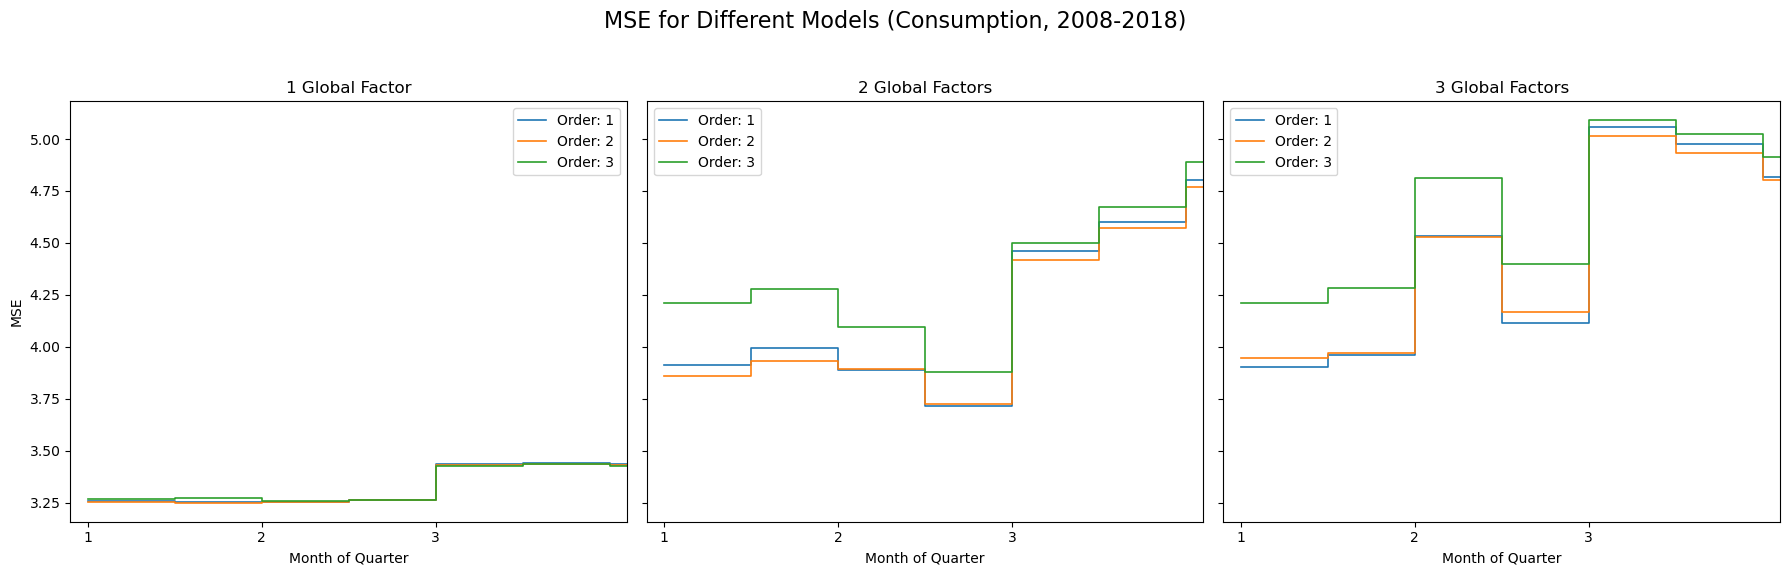

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'Consumption'
text_type = "topics"
estimation_period = "2007"
num_topics = "200"
source = "all"

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}"

# Create a figure with 1 row and 3 columns of subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Loop over each number of global factors (1, 2, and 3)
for i, num_factors in enumerate(range(1, 4)):
    ax = axs[i]
    # Within each subplot, loop over factor orders 1 to 3
    for order in range(1, 4):
        # Construct file name based on the model's parameters
        factors_str = f"Global_{num_factors}_{order}"
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_file_path = os.path.join(mse_dir, mse_file_name)
        
        # Load the MSE values from file
        mse_df = pd.read_csv(mse_file_path)
        # Construct y values based on the vintages
        y_values = [mse_df[col].iloc[0] for col in vintage_col_names]
        
        # Extend the y-values so the step function holds the last value
        y_extended = y_values.copy()
        y_extended.append(y_values[-1]) # Repeat the last value
        
        # Plot the step function for the current model
        ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                 label=f"Order: {order}")
        
    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
    if i == 0:  # Only the leftmost subplot gets the y-axis label
        ax.set_ylabel("MSE")
    ax.legend()

plt.suptitle(f"MSE for Different Models ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_2008-2018_{q_var}")
plt.savefig(f"{base_filename}.png", format="png")
plt.savefig(f"{base_filename}.eps", format="eps")

plt.show()

Plot MSE values for all models evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


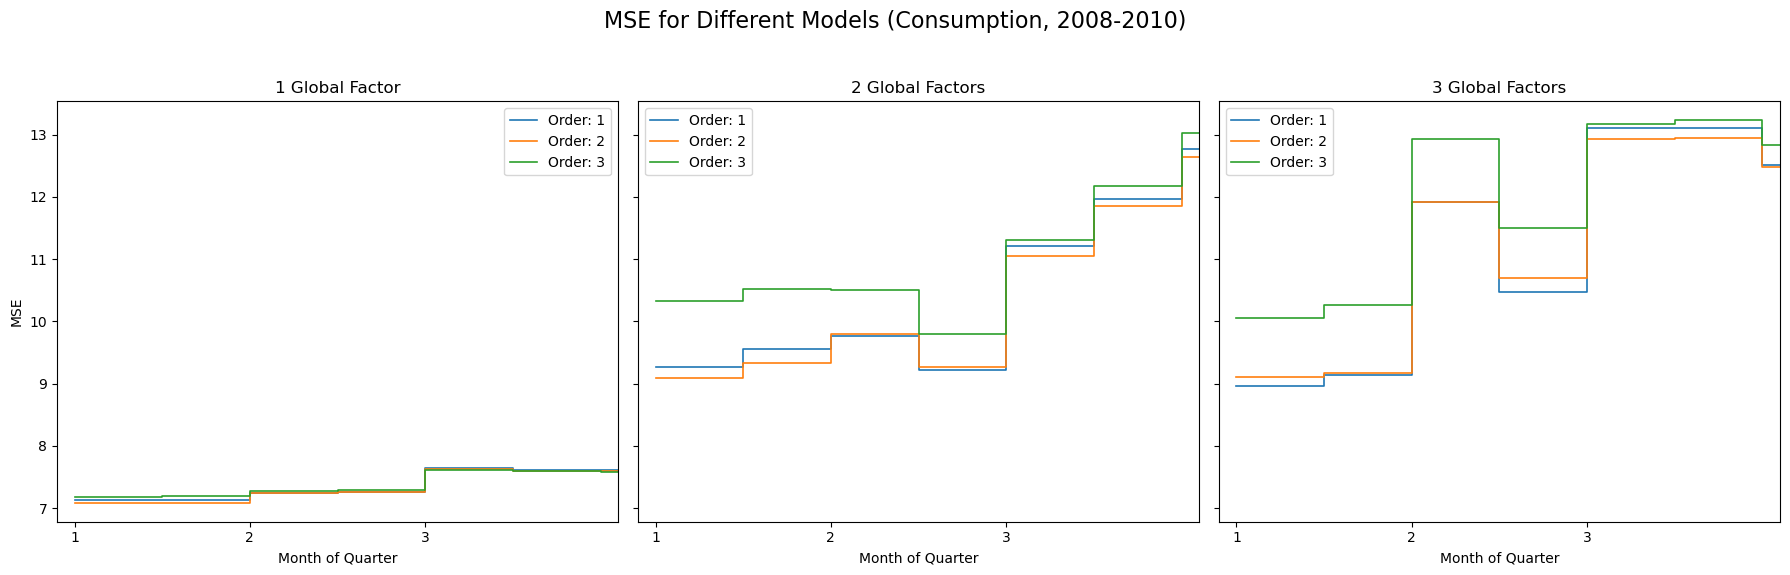

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


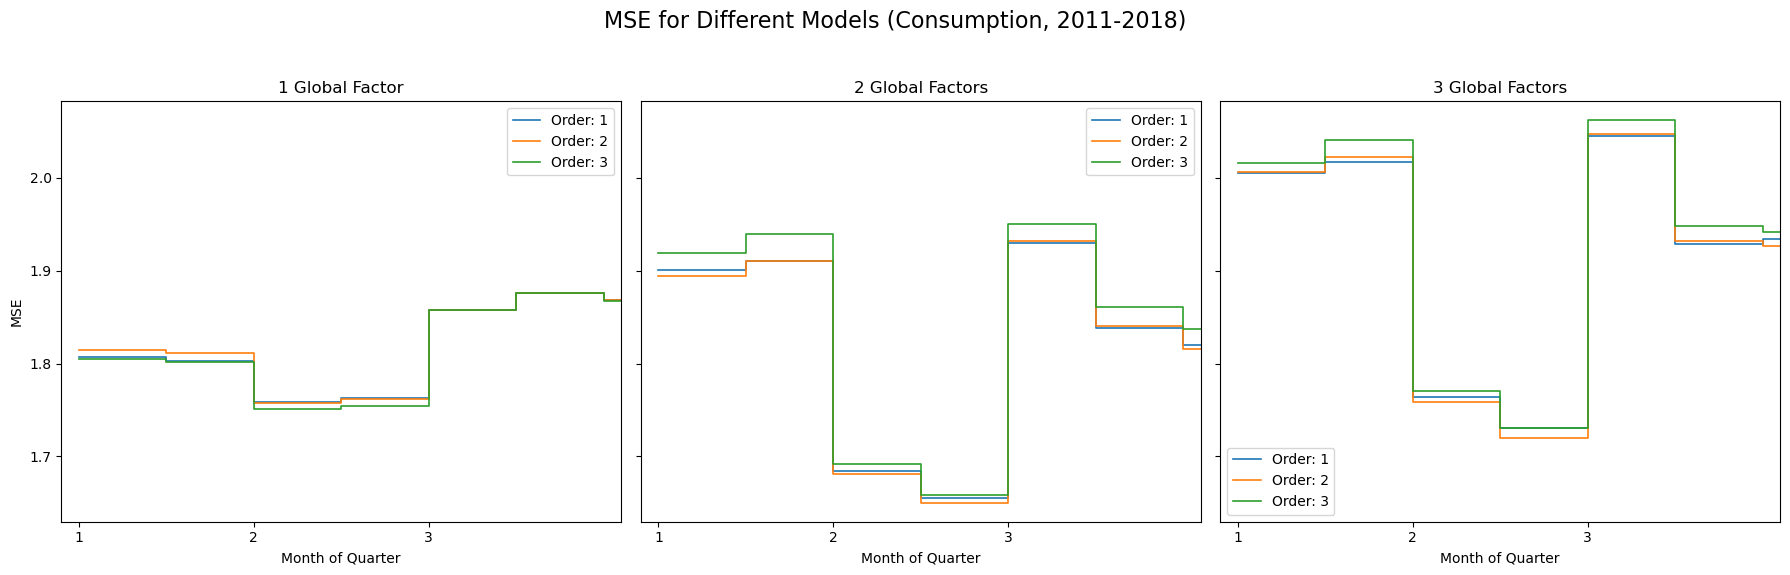

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Consumption'
text_type = "topics"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a figure with 1 row and 3 columns of subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    
    # Loop over each number of global factors (1, 2, and 3)
    for i, num_factors in enumerate(range(1, 4)):
        ax = axs[i]
        # Within each subplot, loop over factor orders 1 to 3
        for order in range(1, 4):
            # Construct forecast file name, e.g., "forecasts_Consumption_Global_1_1.csv"
            factors_str = f"Global_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)
    
            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)
            
            # Merge forecasts with actual growth 
            merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)
            
            # Filter merged data for the current period
            merged_period = merged[ period_filter(merged) ]
            
            # Calculate MSE for each vintage column over the filtered period
            mse_dict = {}
            for col in vintage_col_names:
                mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
                mse_dict[col] = mse
                
            # Construct y values based on the vintages
            y_values = [mse_dict[col] for col in vintage_col_names]
            
            # Extend the y-values so the step function holds the last value
            y_extended = y_values.copy()
            y_extended.append(y_values[-1]) # Repeat the last value
            
            # Plot the step function for the current model (order)
            ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                    label=f"Order: {order}")
            
        # Customize the subplot
        ax.set_xlabel("Month of Quarter")
        # Set ticks only at 1, 2, and 3 to mark the beginning of each month
        ax.set_xticks([1, 2, 3])
        ax.set_xlim(0.9, 4.1)
        ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
        if i == 0:  # Only the leftmost subplot gets the y-axis label
            ax.set_ylabel("MSE")
        ax.legend()
   
    plt.suptitle(f"MSE for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()

Plot forecasts vs actual growth values for all models and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


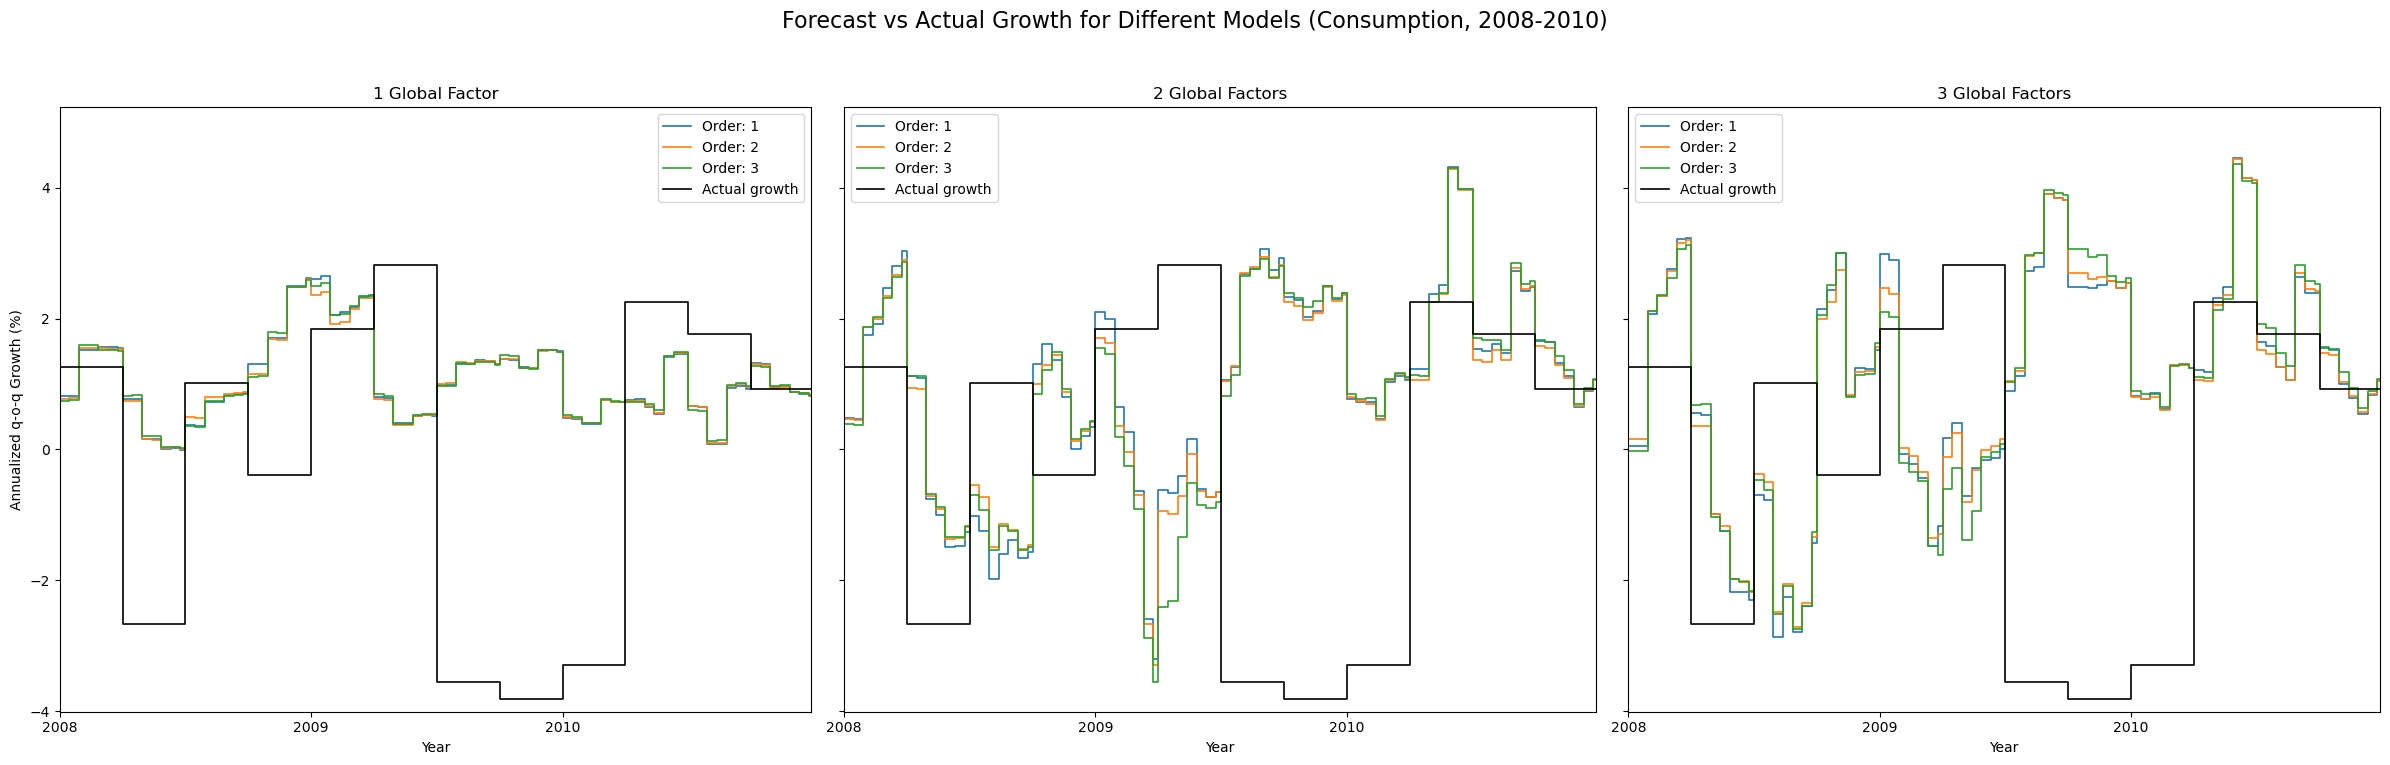

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


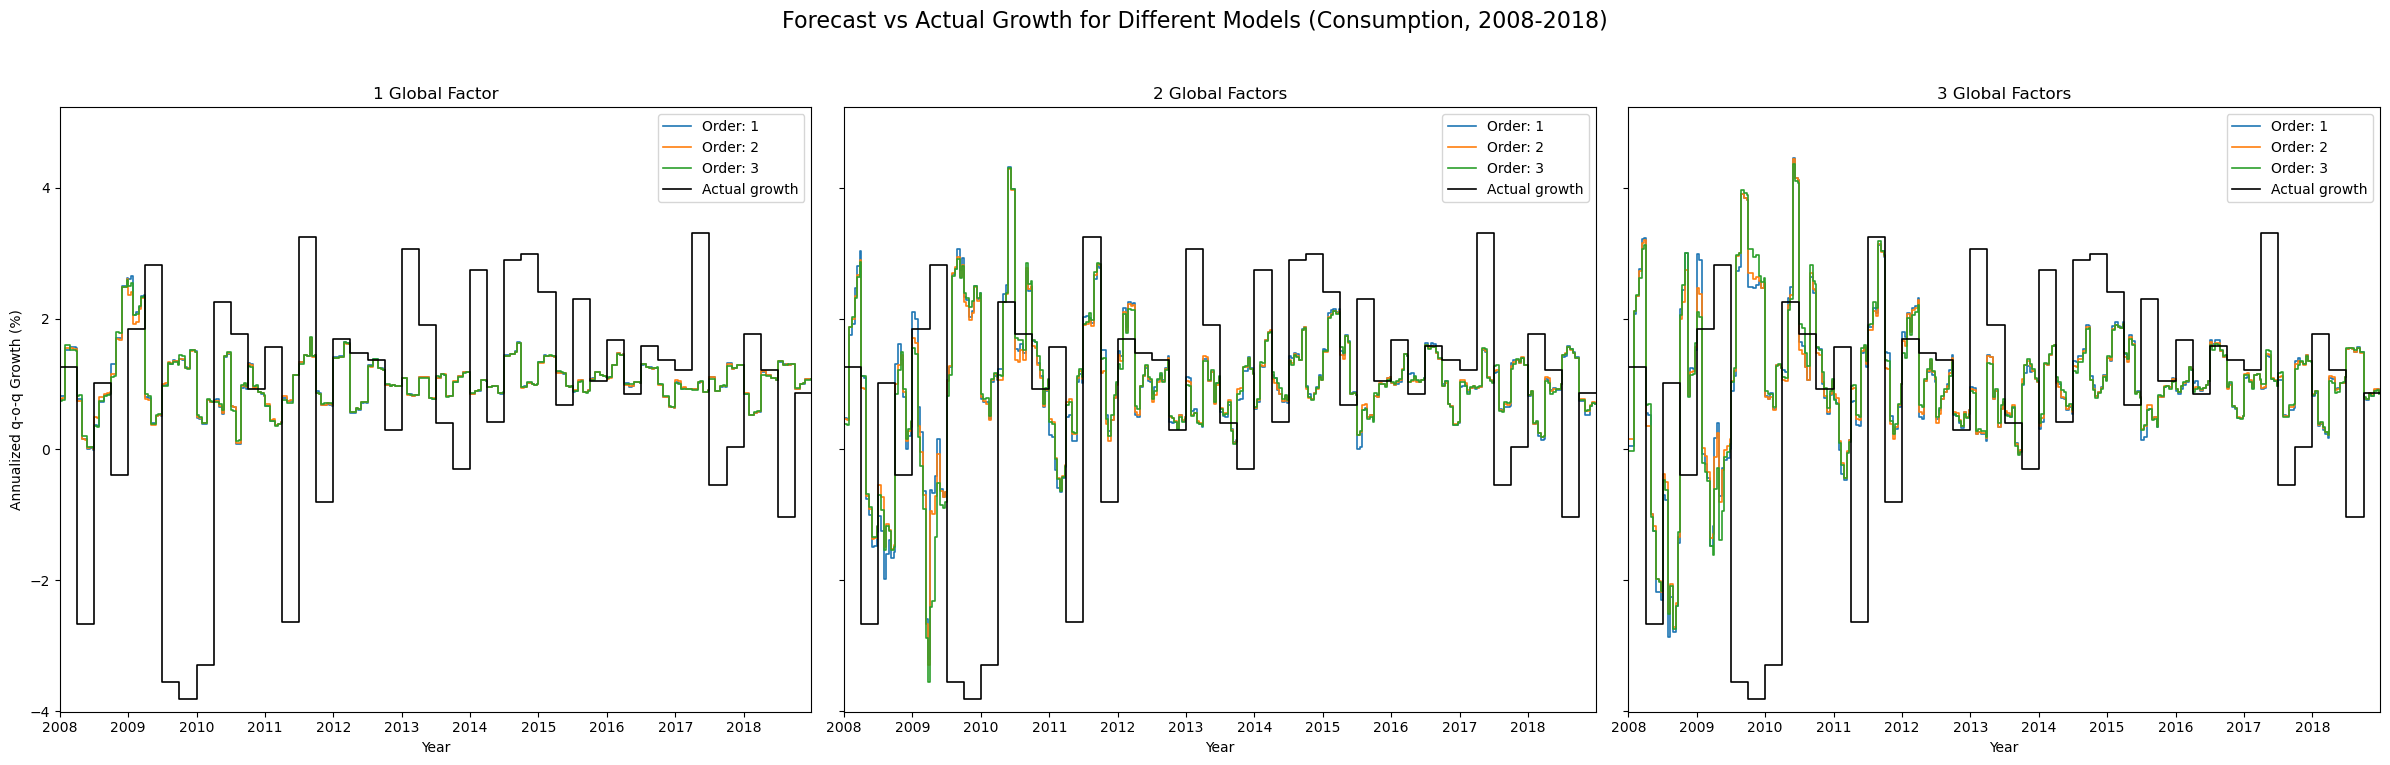

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


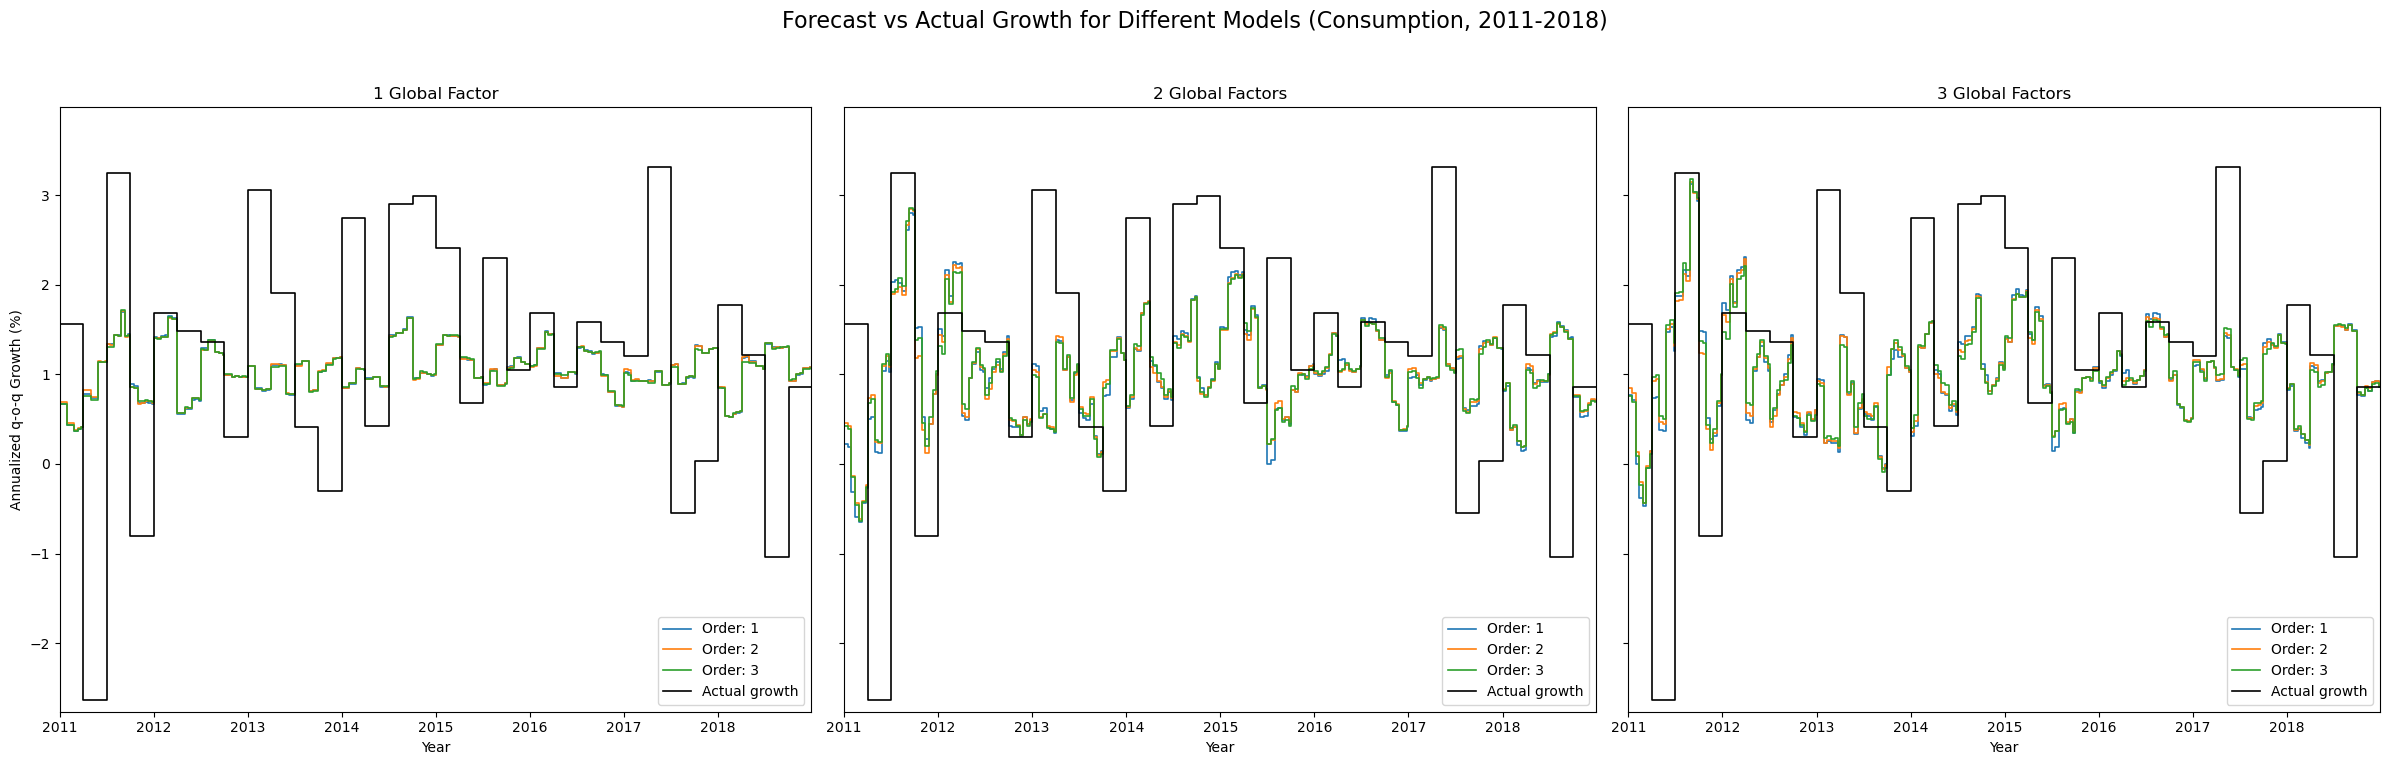

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Consumption'
text_type = "topics"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():
    
    # Extend the actual growth arrays so that the step function continues until the end of the x-axis
    if period_label in ["2008-2018", "2011-2018"]:
        x_act_extended = x_act.copy()
        x_act_extended.append(config["xlim"][1])
        y_act_extended = y_act.copy()
        y_act_extended.append(y_act[-1])
    else:
        x_act_extended = x_act
        y_act_extended = y_act

    # Create a figure with 1 row and 3 columns for the three global factor counts
    fig, axs = plt.subplots(1, 3, figsize=(24, 8), sharey=True)

    # Loop over each global factor count (1, 2, and 3)
    for i, num_factors in enumerate([1, 2, 3]):
        ax = axs[i]

        # For each global factor count, plot forecasts for orders 1, 2, and 3
        for order in range(1, 4):

            # Construct forecast file name, e.g., "forecasts_Consumption_Global_1_1.csv"
            factors_str = f"Global_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)

            # Merge forecasts with actual growth dates
            merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)

            # Build forecast x and y arrays 
            x_fore = []
            y_fore = []
            for idx, row in merged.iterrows():
                base_x = row["date_float"]
                # For each of the 7 vintage columns, define an x-position and take that forecast value
                for j, col in enumerate(vintage_col_names):
                    x_fore.append(base_x + offsets[j])
                    y_fore.append(row[col])

            # Plot the forecast step curve for the current order
            ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

        # Plot actual growth as a step plot in each subplot
        ax.step(x_act_extended, y_act_extended, where='post', color='black', linewidth=1.2, label="Actual growth")

        # Customize the subplot
        ax.set_xlabel("Year")
        ax.set_xlim(config["xlim"][0], config["xlim"][1])
        ax.set_xticks(config["xticks"])
        
        # Set y-axis limits based on the data within the period range
        x_min, x_max = config["xlim"]
        def filter_points(x_arr, y_arr, x_min, x_max):
            return [y for x, y in zip(x_arr, y_arr) if x_min <= x <= x_max]

        # Filter y-values
        y_filtered = filter_points(x_fore, y_fore, x_min, x_max)
        y_act_filtered = filter_points(x_act_extended, y_act_extended, x_min, x_max)
        
        # Combine all filtered y-values
        combined_y = y_filtered + y_act_filtered
        ax.set_ylim(1.05 * min(combined_y), 1.2 * max(combined_y))
        
        ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
        if i == 0:
            ax.set_ylabel("Annualized q-o-q Growth (%)")
        ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_forecast_vs_actual_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()